In [79]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
import seaborn as sns

# Author: Martin Luessi <mluessi@nmr.mgh.harvard.edu>
# License: BSD (3-clause)
from matplotlib.colors import TwoSlopeNorm

import os.path as op
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test

from mne_connectivity import spectral_connectivity_epochs, seed_target_indices
from mne.datasets import sample
from mne_connectivity.viz import plot_sensors_connectivity
from mne.stats import permutation_cluster_test
from scipy import stats as stats
from functools import partial

print(__doc__)

"Coherence


In [132]:
dict015= {'FP1':'eeg','FP2':'eeg','AF7':'eeg','AF3':'eeg','AFz':'eeg','AF4':'eeg','AF8':'eeg','F7':'eeg','F3':'eeg',
          'Fz':'eeg','F4':'eeg','F8':'eeg','FT9':'eeg','FC5':'eeg','FC1':'eeg','FC2':'eeg','FC6':'eeg','FT10':'eeg',
          'T7':'eeg','C3':'eeg','Cz':'eeg','C4':'eeg','T8':'eeg','TP9':'eeg','CP5':'eeg','CP1':'eeg', 'CP2':'eeg',
          'CP6':'eeg','TP10':'eeg','P7':'eeg','P3':'eeg','Pz':'eeg','P4':'eeg','P8':'eeg', 'O1':'eeg','O2':'eeg',
          'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs','DBS6-7':'dbs','DBS7-8':'dbs',
          'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'misc',
          'DynL(lc)':'misc','DynR(lc)':'misc','EmgL':'emg','EmgR':'emg','EmgL(lc)':'emg','EmgR(lc)':'emg'}

dict013_imp = {'FP1':'eeg','FP2':'eeg','AF7':'eeg','AF3':'eeg','AFz':'eeg','AF4':'eeg','AF8':'eeg','F7':'eeg','F3':'eeg',
          'Fz':'eeg','F4':'eeg','F8':'eeg','FC5':'eeg','FC1':'eeg','FC2':'eeg','FC6':'eeg',
          'T7':'eeg','C3':'eeg','Cz':'eeg','C4':'eeg','T8':'eeg','FT9':'eeg','CP5':'eeg','CP1':'eeg', 'CP2':'eeg',
          'CP6':'eeg','FT10':'eeg','TP9':'eeg','P3':'eeg','Pz':'eeg','P4':'eeg','P8':'eeg', 'O1':'eeg','O2':'eeg',
          'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs','DBS6-7':'dbs','DBS7-8':'dbs',
          'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'misc',
          'DynL(lc)':'misc','DynR(lc)':'misc','EmgL':'emg','EmgR':'emg','EmgL(lc)':'emg','EmgR(lc)':'emg'}

dict013_exp = dict015

dict011_imp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg','F4':'eeg','Fz':'eeg','F3':'eeg',
              'F7':'eeg','FC6':'eeg','FC2':'eeg','FC1':'eeg','FC5':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg','T7':'eeg','FT10':'eeg',
               'CP6':'eeg','CP2':'eeg','CP1':'eeg', 'CP5':'eeg', 'FT9':'eeg', 'TP10':'eeg','P4':'eeg','Pz':'eeg','P3':'eeg','P7':'eeg','O2':'eeg',
               'O1':'eeg', 'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs','DBS6-7':'dbs','DBS7-8':'dbs',
              'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'misc',
             'DynR(lc)':'misc', 'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict011_exp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg','F4':'eeg','Fz':'eeg','F3':'eeg',
              'F7':'eeg','FT10':'eeg', 'FC6':'eeg','FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
               'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg', 'CP5':'eeg', 'TP9':'eeg', 'P8':'eeg','P4':'eeg','Pz':'eeg',
               'P3':'eeg','P7':'eeg','O2':'eeg', 'O1':'eeg', 'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs',
               'DBS6-7':'dbs','DBS7-8':'dbs', 'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'misc',
             'DynR(lc)':'misc', 'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}
           
    
#'DBS1-234':'dbs','DBS234-567':'dbs','DBS567-8':'dbs','mean(DBS1-234, DBS234-567, DBS567-8)':'dbs',

dict08_imp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FT10':'eeg','FC6':'eeg',
                'FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
                'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg','CP5':'eeg','TP9':'eeg','P4':'eeg',
                'Pz':'eeg','P3':'eeg','O2':'eeg','O1':'eeg',
                'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs', 
                'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',              
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'misc',             
                'DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict08_exp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FC6':'eeg', 'FC2':'eeg','FC1':'eeg','FC5':'eeg',
                'T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg', 'T7':'eeg','FT10':'eeg', 'CP6':'eeg','CP2':'eeg',
                'CP1':'eeg','CP5':'eeg','FT9':'eeg','TP10':'eeg', 'P4':'eeg','Pz':'eeg','P3':'eeg','P7':'eeg',
                'O2':'eeg','O1':'eeg',
                'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs', 
                'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',              
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'misc',         
                'DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict07_imp= {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FT10':'eeg','FC6':'eeg',
                'FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
                'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg','CP5':'eeg','TP9':'eeg','P4':'eeg',
                'Pz':'eeg','P3':'eeg','O2':'eeg','O1':'eeg',
                'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs',
                'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'misc',
                'DynR':'misc','DynL':'misc','DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict07_exp= {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FT10':'eeg','FC6':'eeg',
                'FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
                'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg','CP5':'eeg','TP9':'eeg','P8':'eeg','P4':'eeg',
                'Pz':'eeg','P3':'eeg','P7':'eeg','O2':'eeg','O1':'eeg',
                'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs',
                'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'misc',
                'DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict_eog= {'FP1':'eog'}

In [133]:
base_dir = "E:/Oddball Data/"
subj_list = ['007','008','011','013','014','015']
subj_list = ['007']

stage = ['implant']#, 'implant']explant
aff_cond = ['1', '101'];
aff_cond_plot = ['Standard', 'Oddball'];

naff_cond = ['10', '110'];

for sub in subj_list:
    for st in stage:
        data_dir = base_dir+"EDEN"+sub+'/ANALYSIS/'
        fname = data_dir+"data_clean"+st+'.mat'
                
        if sub == '015' or sub=='014':
            dict1 = dict015
        elif sub == '013' and st== 'implant':
            dict1 = dict013_imp
        elif sub == '013' and st== 'explant':
            dict1 = dict013_exp
        elif sub == '011' and st== 'implant':
            dict1 = dict011_imp
        elif sub == '011' and st== 'explant':
            dict1 = dict011_exp
        elif sub == '008' and st== 'implant':
            dict1 = dict08_imp
        elif sub == '008' and st== 'explant':
            dict1 = dict08_exp
        elif sub == '007' and st== 'implant':
            dict1 = dict07_imp
        elif sub == '007' and st== 'explant':
            dict1 = dict07_exp

        info = mne.create_info(list(dict1.keys()), sfreq=200, ch_types='misc', verbose=None)
        epochs = mne.read_epochs_fieldtrip(fname,info,data_name='x', trialinfo_column=0)
        
        sfreq = epochs.info['sfreq']
        
        epochs.set_channel_types(dict1)

        kind='easycap-M1'
        mon = mne.channels.make_standard_montage(kind, head_size='auto')
        epochs.set_montage(mon,match_case=False, on_missing='ignore')
        
        epochs.filter(0.05,30)

        epochs_aff_odd = epochs[aff_cond[1]]
        epochs_aff_typ = epochs[aff_cond[0]]

        mne.epochs.equalize_epoch_counts([epochs_aff_odd,epochs_aff_typ], method='truncate')
        
        epochs_aff_odd.set_channel_types(dict_eog)
        epochs_aff_typ.set_channel_types(dict_eog)

   
        
        """Average Baseline"""
        epochs_aff_odd_norm1 =[] 
        for ii,ch in enumerate(epochs_aff_odd.ch_names):
            x = np.hstack(epochs_aff_odd.get_data()[:, ii, :]) # 2D dim = epoch* ch* time to 1D dim, freq * (time *epoch)
        
            x_mean=x.mean() # mean of all the freqs across all the complete experiment session.
            epochs_aff_odd_norm=[]    
            for jj in range(epochs_aff_odd.get_data()[:, ii, :].shape[0]):
                epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
            epochs_aff_odd_norm1.append(epochs_aff_odd_norm)
        epochs_aff_odd_norm1 = np.array(epochs_aff_odd_norm1)
        epochs_aff_odd_norm1 = np.rollaxis(epochs_aff_odd_norm1,1) # normalized epoch data
        
        epochs_aff_odd1 = mne.EpochsArray(epochs_aff_odd_norm1,  epochs_aff_odd.info, events=epochs_aff_odd.events, tmin=epochs_aff_odd.tmin)
        
        
        """Average Baseline"""
        epochs_aff_typ_norm1 =[] 
        for ii,ch in enumerate(epochs_aff_typ.ch_names):
            x = np.hstack(epochs_aff_typ.get_data()[:, ii, :]) # 2D dim = epoch* ch* time to 1D dim, freq * (time *epoch)
        
            x_mean=x.mean() # mean of all the freqs across all the complete experiment session.
            epochs_aff_typ_norm=[]    
            for jj in range(epochs_aff_typ.get_data()[:, ii, :].shape[0]):
                epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
            epochs_aff_typ_norm1.append(epochs_aff_typ_norm)
        epochs_aff_typ_norm1 = np.array(epochs_aff_typ_norm1)
        epochs_aff_typ_norm1 = np.rollaxis(epochs_aff_typ_norm1,1) # normalized epoch data
        
        epochs_aff_typ1 = mne.EpochsArray(epochs_aff_typ_norm1,  epochs_aff_typ.info, events=epochs_aff_typ.events, tmin=epochs_aff_typ.tmin)


seed_chs = epochs_aff_odd1.copy().pick('dbs').ch_names

"""
ch_picks =['Fz','F4','F8','FC2','FC6','Cz', 'C4','CP2','CP6','Pz','P4']
ch_picks.extend(seed_chs)
epochs_aff_odd1.pick(ch_picks)
epochs_aff_typ1.pick(ch_picks)"""

Adding metadata with 9 columns
404 matching events found
No baseline correction applied
Setting up band-pass filter from 0.05 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.05 Hz (-6 dB cutoff frequency: 0.03 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 13201 samples (66.005 s)



C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:40: RuntimeWarning: The unit for channel(s) AF3, AF4, AF7, AF8, AFz, C3, C4, CP1, CP2, CP5, CP6, Cz, DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8, EmgL, EmgL(lc), EmgR, EmgR(lc), F3, F4, F7, F8, FC1, FC2, FC5, FC6, FP1, FP2, FT10, FT9, Fz, O1, O2, P3, P4, Pz, T7, T8, TP10, TP9 has changed from NA to V.
  epochs.set_channel_types(dict1)
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:46: RuntimeWarning: filter_length (13201) is longer than the signal (1801), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(0.05,30)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 647

Dropped 0 epochs: 
Dropped 99 epochs: 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146


C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:61: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x = np.hstack(epochs_aff_odd.get_data()[:, ii, :]) # 2D dim = epoch* ch* time to 1D dim, freq * (time *epoch)
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for jj in range(epochs_aff_odd.get_data()[:, ii, :].shape[0]):
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:66: FutureWarni

C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\User

C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\User

C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\User

C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\User

Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated


C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\User

C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\User

C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\User

C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\User

C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\User

C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\User

C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\User

C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\User

C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\User

C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\User

Not setting metadata
48 matching events found
No baseline correction applied
0 projection items activated


C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\720790421.py:82: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\User

"\nch_picks =['Fz','F4','F8','FC2','FC6','Cz', 'C4','CP2','CP6','Pz','P4']\nch_picks.extend(seed_chs)\nepochs_aff_odd1.pick(ch_picks)\nepochs_aff_typ1.pick(ch_picks)"

In [95]:

ch_picks =['Fz','F4','F8','FC2','FC6','Cz', 'C4','CP2','CP6','Pz','P4']
ch_picks.extend(seed_chs)
epochs_aff_odd1.pick(ch_picks)
epochs_aff_typ1.pick(ch_picks)

<EpochsArray |  48 events (all good), -3 – 6 s, baseline off, ~13.2 MB, data loaded,
 '1': 48>

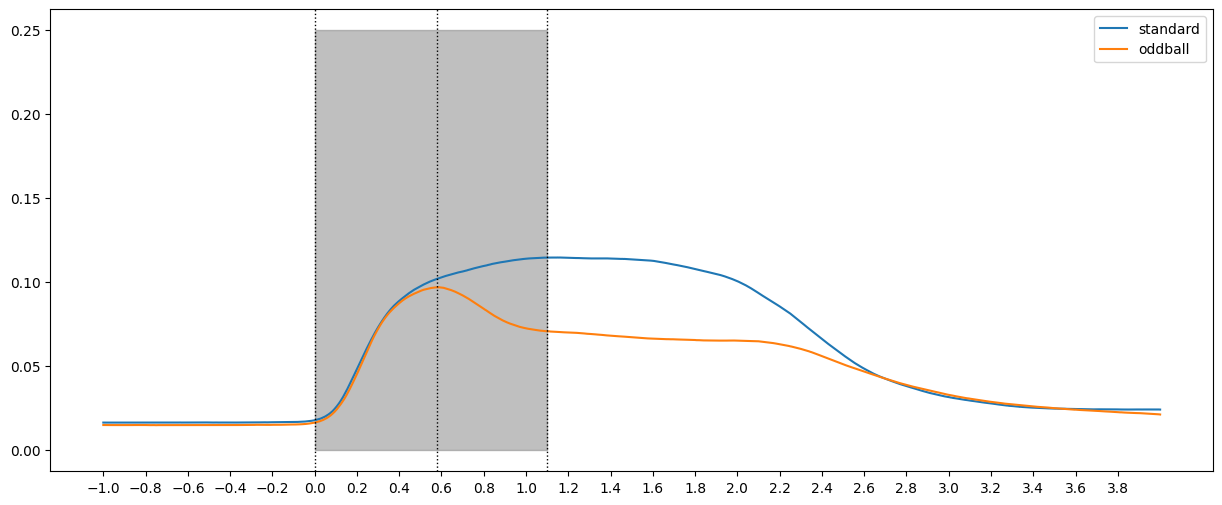

In [134]:
tmin = -1
tmax = 4
Dynmo_odd = epochs_aff_odd.copy().crop(tmin,tmax).get_data(picks='DynL(lc)')
Dynmo_odd= Dynmo_odd.reshape(Dynmo_odd.shape[0],Dynmo_odd.shape[2]).mean(axis=0)

Dynmo_typ = epochs_aff_typ.copy().crop(tmin,tmax).get_data(picks='DynL(lc)')
Dynmo_typ= Dynmo_typ.reshape(Dynmo_typ.shape[0],Dynmo_typ.shape[2]).mean(axis=0)

plt.figure(figsize=(15,6))

time= epochs_aff_typ.copy().crop(-1,tmax).times

plt.plot(epochs_aff_typ.copy().crop(-1,tmax).times,Dynmo_typ)
plt.plot(epochs_aff_odd.copy().crop(-1,tmax).times,Dynmo_odd)

x=np.arange(tmin,tmax,0.2)

plt.xticks(x)

f_max_time = np.argmax(epochs_aff_odd.copy().crop(0,1).get_data(picks='DynL(lc)').reshape(epochs_aff_odd.copy().crop(0,1).get_data(picks='DynL(lc)').shape[0],epochs_aff_odd.copy().crop(0,1).get_data(picks='DynL(lc)').shape[2]).mean(axis=0))/200

plt.axvline(0, linewidth=1, color="black", linestyle=":")

plt.axvline(f_max_time, linewidth=1, color="black", linestyle=":")

plt.axvline(1.1, linewidth=1, color="black", linestyle=":")
plt.fill_betweenx(np.array((0,0.25)), 1.1,0,color='gray', alpha=0.5)

plt.legend(['standard','oddball'])

In [135]:
# Define different time windows to look for coherence in Error detection and Error correction

tmin_coh_lst = [0, f_max_time] #0 # Error detection, Error correction, Full time
tmax_coh_lst = [f_max_time, 1.5] #1.5

In [48]:
""""Coherence"""

# Define different time windows to look for coherence in Error detection and Error correction

tmin_coh_lst = [0, f_max_time] #0 # Error detection, Error correction, Full time
tmax_coh_lst = [f_max_time, 1.5] #1.5

for tmin_coh, tmax_coh in zip(tmin_coh_lst, tmax_coh_lst):

    picks = mne.pick_types(epochs_aff_odd1.info, eeg=True, dbs=True, emg= False,stim=False, eog=False,
                           exclude='bads')

    epochs_aff_odd1.pick(['eeg','dbs'])
    epochs_aff_typ1.pick(['eeg','dbs'])
    
    # Use 'DBS' channels as seed
            
    seed_chs = epochs_aff_odd1.copy().pick('dbs').ch_names
    coh_diff = []
    for seed_ch in seed_chs:
        
        picks_ch_names = epochs_aff_odd1.ch_names
        # Create seed-target indices for connectivity computation
        seed = picks_ch_names.index(seed_ch)
        targets = np.arange(len(picks))
        indices = seed_target_indices(seed, targets)    
    
        freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']
        min_freq = (4, 8,13,21)
        max_freq = (7, 12,20,30)    
        
        # Define wavelet frequencies and number of cycles
        cwt_freqs = np.arange(1, 41, 1)
        cwt_n_cycles = 7
    
        # Run the connectivity analysis using 2 parallel jobs
        con_odd = spectral_connectivity_epochs(
            epochs_aff_odd1, indices=indices,
            method='coh', mode='cwt_morlet', sfreq=sfreq, fmin = min_freq, fmax = max_freq, faverage =True, tmin = tmin_coh, tmax =tmax_coh,
            cwt_freqs=cwt_freqs, cwt_n_cycles=cwt_n_cycles, n_jobs=30)
    
        con_typ = spectral_connectivity_epochs(
            epochs_aff_typ1, indices=indices,
            method='coh', mode='cwt_morlet', sfreq=sfreq, fmin = min_freq, fmax = max_freq, faverage =True, tmin = tmin_coh, tmax =tmax_coh,
            cwt_freqs=cwt_freqs, cwt_n_cycles=cwt_n_cycles, n_jobs=30)
    
        times = con_odd.times
        freqs = con_odd.freqs
    
        # Mark the seed channel with a value of 1.0, so we can see it in the plot
        # con_odd.get_data()[np.where(indices[1] == seed)] = 1.0
        # con_typ.get_data()[np.where(indices[1] == seed)] = 1.0
    
        #layout = mne.find_layout(epochs.info, 'eeg')  # use full layout
        tfr_odd = mne.time_frequency.AverageTFR(epochs_aff_odd1.info, con_odd.get_data(), times, freqs, len(epochs_aff_odd1))
        #tfr_odd.save(data_dir+'tfr_odd'+st+seed_ch+'-tfr.h5',overwrite =True)
    
        tfr_typ = mne.time_frequency.AverageTFR(epochs_aff_typ1.info, con_typ.get_data(), times, freqs, len(epochs_aff_typ1))
        #tfr_typ.save(data_dir+'tfr_typ'+st+seed_ch+'-tfr.h5',overwrite =True)
        
        # TFR differences in freq bands and time period 0 to 1.5s
    
        tfr = tfr_odd- tfr_typ
    
        freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']
            
        n_channels = len(tfr.copy().pick('eeg').ch_names)
        X1 = []
        for n, band in enumerate(freq_band):
            tfr_ch = []
            for ch in range(n_channels):
                tfr_ch.append((tfr.data[:,:,:].mean(axis=2)[ch,n]))
    
            tfr_ch = np.array(tfr_ch).reshape(n_channels,1)   
            X1.append(tfr_ch)
    
        coh_diff.append(X1)
    
    coh_diff = np.array(coh_diff)
    
    file = f"{base_dir}coh_diff_{sub}_{st}_{tmin_coh}_{tmax_coh}"

    np.save(file, coh_diff)

Connectivity computation...
    computing connectivity for 40 connections
    using t=0.000s..0.655s for estimation (132 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..30


C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:37: RuntimeWarning: There were no Annotations stored in <EpochsArray |  78 events (all good), -3 – 6 s, baseline off, ~42.9 MB, data loaded,
 '101': 78>, so metadata was not modified.
  con_odd = spectral_connectivity_epochs(
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:37: RuntimeWarning: fmin=4.000 Hz corresponds to 2.640 < 5 cycles based on the epoch length 0.660 sec, need at least 1.250 sec epochs or fmin=7.576. Spectrum estimate will be unreliable.
  con_odd = spectral_connectivity_epochs(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   1 out of   1 | elapsed:    6.8s finished
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:   17.1s remaining:   47.2s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:   19.4s remaining:   19.4s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:   20.7s remaining:    7.5s


    computing connectivity for epochs 31..60


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:   21.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.5s remaining:    0.1s


    computing connectivity for epochs 61..78


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    5.7s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   5 out of  18 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=30)]: Done   9 out of  18 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=30)]: Done  13 out of  18 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  18 out of  18 | elapsed:    0.4s finished


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 40 connections
    using t=0.000s..0.655s for estimation (132 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..30


C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:42: RuntimeWarning: There were no Annotations stored in <EpochsArray |  78 events (all good), -3 – 6 s, baseline off, ~42.9 MB, data loaded,
 '1': 78>, so metadata was not modified.
  con_typ = spectral_connectivity_epochs(
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:42: RuntimeWarning: fmin=4.000 Hz corresponds to 2.640 < 5 cycles based on the epoch length 0.660 sec, need at least 1.250 sec epochs or fmin=7.576. Spectrum estimate will be unreliable.
  con_typ = spectral_connectivity_epochs(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.4s remaining:    1.2s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.6s remaining:    0.1s


    computing connectivity for epochs 31..60


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.6s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.4s remaining:    1.4s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.5s remaining:    0.5s


    computing connectivity for epochs 61..78


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.8s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   5 out of  18 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=30)]: Done   9 out of  18 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  13 out of  18 | elapsed:    0.3s remaining:    0.1s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 40 connections
    using t=0.000s..0.655s for estimation (132 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..30


[Parallel(n_jobs=30)]: Done  18 out of  18 | elapsed:    0.4s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:37: RuntimeWarning: There were no Annotations stored in <EpochsArray |  78 events (all good), -3 – 6 s, baseline off, ~42.9 MB, data loaded,
 '101': 78>, so metadata was not modified.
  con_odd = spectral_connectivity_epochs(
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:37: RuntimeWarning: fmin=4.000 Hz corresponds to 2.640 < 5 cycles based on the epoch length 0.660 sec, need at least 1.250 sec epochs or fmin=7.576. Spectrum estimate will be unreliable.
  con_odd = spectral_connectivity_epochs(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.5s remaining:    0.5s


    computing connectivity for epochs 31..60


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.5s remaining:    0.1s


    computing connectivity for epochs 61..78


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.6s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...


[Parallel(n_jobs=30)]: Done   5 out of  18 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=30)]: Done   9 out of  18 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  13 out of  18 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  18 out of  18 | elapsed:    0.3s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:42: RuntimeWarning: There were no Annotations stored in <EpochsArray |  78 events (all good), -3 – 6 s, baseline off, ~42.9 MB, data loaded,
 '1': 78>, so metadata was not modified.
  con_typ = spectral_connectivity_epochs(


    computing connectivity for 40 connections
    using t=0.000s..0.655s for estimation (132 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..30


C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:42: RuntimeWarning: fmin=4.000 Hz corresponds to 2.640 < 5 cycles based on the epoch length 0.660 sec, need at least 1.250 sec epochs or fmin=7.576. Spectrum estimate will be unreliable.
  con_typ = spectral_connectivity_epochs(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.4s remaining:    0.4s


    computing connectivity for epochs 31..60


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.6s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.5s remaining:    0.5s


    computing connectivity for epochs 61..78


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]


[Parallel(n_jobs=30)]: Done   5 out of  18 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=30)]: Done   9 out of  18 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  13 out of  18 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  18 out of  18 | elapsed:    0.3s finished


Connectivity computation...
    computing connectivity for 40 connections
    using t=0.000s..0.655s for estimation (132 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..30


C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:37: RuntimeWarning: There were no Annotations stored in <EpochsArray |  78 events (all good), -3 – 6 s, baseline off, ~42.9 MB, data loaded,
 '101': 78>, so metadata was not modified.
  con_odd = spectral_connectivity_epochs(
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:37: RuntimeWarning: fmin=4.000 Hz corresponds to 2.640 < 5 cycles based on the epoch length 0.660 sec, need at least 1.250 sec epochs or fmin=7.576. Spectrum estimate will be unreliable.
  con_odd = spectral_connectivity_epochs(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.4s remaining:    0.1s


    computing connectivity for epochs 31..60


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.5s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.4s remaining:    0.4s


    computing connectivity for epochs 61..78


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.6s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   5 out of  18 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=30)]: Done   9 out of  18 | elapsed:    0.4s remaining:    0.4s


[Connectivity computation done]


[Parallel(n_jobs=30)]: Done  13 out of  18 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  18 out of  18 | elapsed:    0.7s finished


Connectivity computation...
    computing connectivity for 40 connections
    using t=0.000s..0.655s for estimation (132 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..30


C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:42: RuntimeWarning: There were no Annotations stored in <EpochsArray |  78 events (all good), -3 – 6 s, baseline off, ~42.9 MB, data loaded,
 '1': 78>, so metadata was not modified.
  con_typ = spectral_connectivity_epochs(
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:42: RuntimeWarning: fmin=4.000 Hz corresponds to 2.640 < 5 cycles based on the epoch length 0.660 sec, need at least 1.250 sec epochs or fmin=7.576. Spectrum estimate will be unreliable.
  con_typ = spectral_connectivity_epochs(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.8s remaining:    2.3s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    1.1s remaining:    1.1s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    1.3s finished


    computing connectivity for epochs 31..60


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.5s remaining:    0.1s


    computing connectivity for epochs 61..78


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.6s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   5 out of  18 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=30)]: Done   9 out of  18 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=30)]: Done  13 out of  18 | elapsed:    0.5s remaining:    0.1s


[Connectivity computation done]


[Parallel(n_jobs=30)]: Done  18 out of  18 | elapsed:    0.6s finished


Connectivity computation...
    computing connectivity for 40 connections
    using t=0.000s..0.655s for estimation (132 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..30


C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:37: RuntimeWarning: There were no Annotations stored in <EpochsArray |  78 events (all good), -3 – 6 s, baseline off, ~42.9 MB, data loaded,
 '101': 78>, so metadata was not modified.
  con_odd = spectral_connectivity_epochs(
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:37: RuntimeWarning: fmin=4.000 Hz corresponds to 2.640 < 5 cycles based on the epoch length 0.660 sec, need at least 1.250 sec epochs or fmin=7.576. Spectrum estimate will be unreliable.
  con_odd = spectral_connectivity_epochs(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    2.5s remaining:    7.1s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    2.6s remaining:    2.6s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    2.7s remaining:    0.9s


    computing connectivity for epochs 31..60


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    2.8s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.4s remaining:    0.4s


    computing connectivity for epochs 61..78


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...


[Parallel(n_jobs=30)]: Done   5 out of  18 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=30)]: Done   9 out of  18 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  13 out of  18 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  18 out of  18 | elapsed:    0.3s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:42: RuntimeWarning: There were no Annotations stored in <EpochsArray |  78 events (all good), -3 – 6 s, baseline off, ~42.9 MB, data loaded,
 '1': 78>, so metadata was not modified.
  con_typ = spectral_connectivity_epochs(


    computing connectivity for 40 connections
    using t=0.000s..0.655s for estimation (132 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..30


C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:42: RuntimeWarning: fmin=4.000 Hz corresponds to 2.640 < 5 cycles based on the epoch length 0.660 sec, need at least 1.250 sec epochs or fmin=7.576. Spectrum estimate will be unreliable.
  con_typ = spectral_connectivity_epochs(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.6s remaining:    1.8s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    1.1s remaining:    0.3s


    computing connectivity for epochs 31..60


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    1.2s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.4s remaining:    0.4s


    computing connectivity for epochs 61..78


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.6s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   5 out of  18 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=30)]: Done   9 out of  18 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  13 out of  18 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  18 out of  18 | elapsed:    0.3s finished


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 40 connections
    using t=0.000s..0.655s for estimation (132 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..30


C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:37: RuntimeWarning: There were no Annotations stored in <EpochsArray |  78 events (all good), -3 – 6 s, baseline off, ~42.9 MB, data loaded,
 '101': 78>, so metadata was not modified.
  con_odd = spectral_connectivity_epochs(
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:37: RuntimeWarning: fmin=4.000 Hz corresponds to 2.640 < 5 cycles based on the epoch length 0.660 sec, need at least 1.250 sec epochs or fmin=7.576. Spectrum estimate will be unreliable.
  con_odd = spectral_connectivity_epochs(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.4s remaining:    0.4s


    computing connectivity for epochs 31..60


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.5s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.4s remaining:    0.4s


    computing connectivity for epochs 61..78


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   5 out of  18 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=30)]: Done   9 out of  18 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  13 out of  18 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  18 out of  18 | elapsed:    0.3s finished


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 40 connections
    using t=0.000s..0.655s for estimation (132 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..30


C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:42: RuntimeWarning: There were no Annotations stored in <EpochsArray |  78 events (all good), -3 – 6 s, baseline off, ~42.9 MB, data loaded,
 '1': 78>, so metadata was not modified.
  con_typ = spectral_connectivity_epochs(
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:42: RuntimeWarning: fmin=4.000 Hz corresponds to 2.640 < 5 cycles based on the epoch length 0.660 sec, need at least 1.250 sec epochs or fmin=7.576. Spectrum estimate will be unreliable.
  con_typ = spectral_connectivity_epochs(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.4s remaining:    0.4s


    computing connectivity for epochs 31..60


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.5s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.5s remaining:    0.5s


    computing connectivity for epochs 61..78


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.6s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   5 out of  18 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=30)]: Done   9 out of  18 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=30)]: Done  13 out of  18 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  18 out of  18 | elapsed:    0.4s finished


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 40 connections
    using t=0.000s..0.655s for estimation (132 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..30


C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:37: RuntimeWarning: There were no Annotations stored in <EpochsArray |  78 events (all good), -3 – 6 s, baseline off, ~42.9 MB, data loaded,
 '101': 78>, so metadata was not modified.
  con_odd = spectral_connectivity_epochs(
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:37: RuntimeWarning: fmin=4.000 Hz corresponds to 2.640 < 5 cycles based on the epoch length 0.660 sec, need at least 1.250 sec epochs or fmin=7.576. Spectrum estimate will be unreliable.
  con_odd = spectral_connectivity_epochs(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.5s remaining:    0.5s


    computing connectivity for epochs 31..60


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    1.1s remaining:    3.3s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    1.3s remaining:    1.3s


    computing connectivity for epochs 61..78


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    1.4s remaining:    0.4s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    1.5s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   5 out of  18 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=30)]: Done   9 out of  18 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=30)]: Done  13 out of  18 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  18 out of  18 | elapsed:    0.4s finished


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 40 connections
    using t=0.000s..0.655s for estimation (132 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..30


C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:42: RuntimeWarning: There were no Annotations stored in <EpochsArray |  78 events (all good), -3 – 6 s, baseline off, ~42.9 MB, data loaded,
 '1': 78>, so metadata was not modified.
  con_typ = spectral_connectivity_epochs(
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:42: RuntimeWarning: fmin=4.000 Hz corresponds to 2.640 < 5 cycles based on the epoch length 0.660 sec, need at least 1.250 sec epochs or fmin=7.576. Spectrum estimate will be unreliable.
  con_typ = spectral_connectivity_epochs(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    1.0s


    computing connectivity for epochs 31..60


[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.6s remaining:    0.6s


    computing connectivity for epochs 61..78


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.9s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   5 out of  18 | elapsed:    0.6s remaining:    1.7s
[Parallel(n_jobs=30)]: Done   9 out of  18 | elapsed:    1.1s remaining:    1.1s
[Parallel(n_jobs=30)]: Done  13 out of  18 | elapsed:    1.3s remaining:    0.5s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 40 connections
    using t=0.000s..0.655s for estimation (132 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..30


[Parallel(n_jobs=30)]: Done  18 out of  18 | elapsed:    1.6s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:37: RuntimeWarning: There were no Annotations stored in <EpochsArray |  78 events (all good), -3 – 6 s, baseline off, ~42.9 MB, data loaded,
 '101': 78>, so metadata was not modified.
  con_odd = spectral_connectivity_epochs(
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:37: RuntimeWarning: fmin=4.000 Hz corresponds to 2.640 < 5 cycles based on the epoch length 0.660 sec, need at least 1.250 sec epochs or fmin=7.576. Spectrum estimate will be unreliable.
  con_odd = spectral_connectivity_epochs(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.4s remaining:    1.2s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.5s remaining:    0.5s


    computing connectivity for epochs 31..60


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.5s remaining:    0.1s


    computing connectivity for epochs 61..78


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.6s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 40 connections
    using t=0.000s..0.655s for estimation (132 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..30


[Parallel(n_jobs=30)]: Done   5 out of  18 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=30)]: Done   9 out of  18 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=30)]: Done  13 out of  18 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  18 out of  18 | elapsed:    0.3s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:42: RuntimeWarning: There were no Annotations stored in <EpochsArray |  78 events (all good), -3 – 6 s, baseline off, ~42.9 MB, data loaded,
 '1': 78>, so metadata was not modified.
  con_typ = spectral_connectivity_epochs(
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:42: RuntimeWarning: fmin=4.000 Hz corresponds to 2.640 < 5 cycles based on the epoch length 0.660 sec, need at least 1.250 sec epochs or fmin=7.576. Spectrum estimate will be unreliable.
  con_typ = spectral_connectivity_epochs(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: D

    computing connectivity for epochs 31..60


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.5s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.6s remaining:    0.6s


    computing connectivity for epochs 61..78


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.8s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[Connectivity computation done]


[Parallel(n_jobs=30)]: Done   5 out of  18 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=30)]: Done   9 out of  18 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=30)]: Done  13 out of  18 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  18 out of  18 | elapsed:    0.5s finished


Connectivity computation...
    computing connectivity for 40 connections
    using t=0.655s..1.500s for estimation (170 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..30


C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:37: RuntimeWarning: There were no Annotations stored in <EpochsArray |  78 events (all good), -3 – 6 s, baseline off, ~42.9 MB, data loaded,
 '101': 78>, so metadata was not modified.
  con_odd = spectral_connectivity_epochs(
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:37: RuntimeWarning: fmin=4.000 Hz corresponds to 3.400 < 5 cycles based on the epoch length 0.850 sec, need at least 1.250 sec epochs or fmin=5.882. Spectrum estimate will be unreliable.
  con_odd = spectral_connectivity_epochs(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.9s remaining:    2.6s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    1.1s remaining:    1.1s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    1.3s remaining:    0.4s


    computing connectivity for epochs 31..60


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    1.4s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.4s remaining:    1.2s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.5s remaining:    0.5s


    computing connectivity for epochs 61..78


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   5 out of  18 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=30)]: Done   9 out of  18 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  13 out of  18 | elapsed:    0.3s remaining:    0.1s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 40 connections
    using t=0.655s..1.500s for estimation (170 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..30


[Parallel(n_jobs=30)]: Done  18 out of  18 | elapsed:    0.4s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:42: RuntimeWarning: There were no Annotations stored in <EpochsArray |  78 events (all good), -3 – 6 s, baseline off, ~42.9 MB, data loaded,
 '1': 78>, so metadata was not modified.
  con_typ = spectral_connectivity_epochs(
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:42: RuntimeWarning: fmin=4.000 Hz corresponds to 3.400 < 5 cycles based on the epoch length 0.850 sec, need at least 1.250 sec epochs or fmin=5.882. Spectrum estimate will be unreliable.
  con_typ = spectral_connectivity_epochs(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.6s remaining:    0.6s


    computing connectivity for epochs 31..60


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.9s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.5s remaining:    0.5s


    computing connectivity for epochs 61..78


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   5 out of  18 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=30)]: Done   9 out of  18 | elapsed:    0.4s remaining:    0.4s


[Connectivity computation done]
Connectivity computation...


[Parallel(n_jobs=30)]: Done  13 out of  18 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  18 out of  18 | elapsed:    0.7s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:37: RuntimeWarning: There were no Annotations stored in <EpochsArray |  78 events (all good), -3 – 6 s, baseline off, ~42.9 MB, data loaded,
 '101': 78>, so metadata was not modified.
  con_odd = spectral_connectivity_epochs(


    computing connectivity for 40 connections
    using t=0.655s..1.500s for estimation (170 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..30


C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:37: RuntimeWarning: fmin=4.000 Hz corresponds to 3.400 < 5 cycles based on the epoch length 0.850 sec, need at least 1.250 sec epochs or fmin=5.882. Spectrum estimate will be unreliable.
  con_odd = spectral_connectivity_epochs(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.8s finished


    computing connectivity for epochs 31..60


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.5s remaining:    1.6s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.7s remaining:    0.7s


    computing connectivity for epochs 61..78


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.9s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   5 out of  18 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=30)]: Done   9 out of  18 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=30)]: Done  13 out of  18 | elapsed:    0.4s remaining:    0.1s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 40 connections
    using t=0.655s..1.500s for estimation (170 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..30


[Parallel(n_jobs=30)]: Done  18 out of  18 | elapsed:    0.4s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:42: RuntimeWarning: There were no Annotations stored in <EpochsArray |  78 events (all good), -3 – 6 s, baseline off, ~42.9 MB, data loaded,
 '1': 78>, so metadata was not modified.
  con_typ = spectral_connectivity_epochs(
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:42: RuntimeWarning: fmin=4.000 Hz corresponds to 3.400 < 5 cycles based on the epoch length 0.850 sec, need at least 1.250 sec epochs or fmin=5.882. Spectrum estimate will be unreliable.
  con_typ = spectral_connectivity_epochs(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.7s remaining:    0.2s


    computing connectivity for epochs 31..60


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.8s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.4s remaining:    1.1s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.6s remaining:    0.2s


    computing connectivity for epochs 61..78


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   5 out of  18 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=30)]: Done   9 out of  18 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=30)]: Done  13 out of  18 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  18 out of  18 | elapsed:    0.4s finished


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 40 connections
    using t=0.655s..1.500s for estimation (170 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..30


C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:37: RuntimeWarning: There were no Annotations stored in <EpochsArray |  78 events (all good), -3 – 6 s, baseline off, ~42.9 MB, data loaded,
 '101': 78>, so metadata was not modified.
  con_odd = spectral_connectivity_epochs(
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:37: RuntimeWarning: fmin=4.000 Hz corresponds to 3.400 < 5 cycles based on the epoch length 0.850 sec, need at least 1.250 sec epochs or fmin=5.882. Spectrum estimate will be unreliable.
  con_odd = spectral_connectivity_epochs(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.6s remaining:    0.6s


    computing connectivity for epochs 31..60


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.8s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    1.1s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.5s remaining:    0.5s


    computing connectivity for epochs 61..78


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.8s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   5 out of  18 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=30)]: Done   9 out of  18 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  13 out of  18 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  18 out of  18 | elapsed:    0.3s finished


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 40 connections
    using t=0.655s..1.500s for estimation (170 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..30


C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:42: RuntimeWarning: There were no Annotations stored in <EpochsArray |  78 events (all good), -3 – 6 s, baseline off, ~42.9 MB, data loaded,
 '1': 78>, so metadata was not modified.
  con_typ = spectral_connectivity_epochs(
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:42: RuntimeWarning: fmin=4.000 Hz corresponds to 3.400 < 5 cycles based on the epoch length 0.850 sec, need at least 1.250 sec epochs or fmin=5.882. Spectrum estimate will be unreliable.
  con_typ = spectral_connectivity_epochs(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.4s remaining:    0.4s


    computing connectivity for epochs 31..60


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    1.9s remaining:    5.4s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    2.0s remaining:    2.0s


    computing connectivity for epochs 61..78


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    2.2s remaining:    0.7s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    2.3s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   5 out of  18 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=30)]: Done   9 out of  18 | elapsed:    0.4s remaining:    0.4s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 40 connections
    using t=0.655s..1.500s for estimation (170 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra


[Parallel(n_jobs=30)]: Done  13 out of  18 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  18 out of  18 | elapsed:    0.6s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:37: RuntimeWarning: There were no Annotations stored in <EpochsArray |  78 events (all good), -3 – 6 s, baseline off, ~42.9 MB, data loaded,
 '101': 78>, so metadata was not modified.
  con_odd = spectral_connectivity_epochs(
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:37: RuntimeWarning: fmin=4.000 Hz corresponds to 3.400 < 5 cycles based on the epoch length 0.850 sec, need at least 1.250 sec epochs or fmin=5.882. Spectrum estimate will be unreliable.
  con_odd = spectral_connectivity_epochs(


    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..30


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.5s remaining:    0.5s


    computing connectivity for epochs 31..60


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.8s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    1.0s remaining:    3.0s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    1.3s remaining:    1.3s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    1.5s remaining:    0.5s


    computing connectivity for epochs 61..78


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    1.6s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   5 out of  18 | elapsed:    0.9s remaining:    2.4s


[Connectivity computation done]
Connectivity computation...


[Parallel(n_jobs=30)]: Done   9 out of  18 | elapsed:    1.1s remaining:    1.1s
[Parallel(n_jobs=30)]: Done  13 out of  18 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=30)]: Done  18 out of  18 | elapsed:    1.2s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:42: RuntimeWarning: There were no Annotations stored in <EpochsArray |  78 events (all good), -3 – 6 s, baseline off, ~42.9 MB, data loaded,
 '1': 78>, so metadata was not modified.
  con_typ = spectral_connectivity_epochs(


    computing connectivity for 40 connections
    using t=0.655s..1.500s for estimation (170 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..30


C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:42: RuntimeWarning: fmin=4.000 Hz corresponds to 3.400 < 5 cycles based on the epoch length 0.850 sec, need at least 1.250 sec epochs or fmin=5.882. Spectrum estimate will be unreliable.
  con_typ = spectral_connectivity_epochs(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.4s remaining:    1.2s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.5s remaining:    0.5s


    computing connectivity for epochs 31..60


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.8s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.7s remaining:    2.1s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.9s remaining:    0.3s


    computing connectivity for epochs 61..78


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    1.0s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   5 out of  18 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=30)]: Done   9 out of  18 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=30)]: Done  13 out of  18 | elapsed:    0.3s remaining:    0.1s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 40 connections
    using t=0.655s..1.500s for estimation (170 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..30


[Parallel(n_jobs=30)]: Done  18 out of  18 | elapsed:    0.4s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:37: RuntimeWarning: There were no Annotations stored in <EpochsArray |  78 events (all good), -3 – 6 s, baseline off, ~42.9 MB, data loaded,
 '101': 78>, so metadata was not modified.
  con_odd = spectral_connectivity_epochs(
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:37: RuntimeWarning: fmin=4.000 Hz corresponds to 3.400 < 5 cycles based on the epoch length 0.850 sec, need at least 1.250 sec epochs or fmin=5.882. Spectrum estimate will be unreliable.
  con_odd = spectral_connectivity_epochs(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.5s remaining:    1.6s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.6s remaining:    0.6s


    computing connectivity for epochs 31..60


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.8s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    1.3s remaining:    3.6s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    1.4s remaining:    1.4s


    computing connectivity for epochs 61..78


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    1.6s remaining:    0.5s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    1.7s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   5 out of  18 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=30)]: Done   9 out of  18 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=30)]: Done  13 out of  18 | elapsed:    0.4s remaining:    0.1s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 40 connections
    using t=0.655s..1.500s for estimation (170 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..30


[Parallel(n_jobs=30)]: Done  18 out of  18 | elapsed:    0.5s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:42: RuntimeWarning: There were no Annotations stored in <EpochsArray |  78 events (all good), -3 – 6 s, baseline off, ~42.9 MB, data loaded,
 '1': 78>, so metadata was not modified.
  con_typ = spectral_connectivity_epochs(
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:42: RuntimeWarning: fmin=4.000 Hz corresponds to 3.400 < 5 cycles based on the epoch length 0.850 sec, need at least 1.250 sec epochs or fmin=5.882. Spectrum estimate will be unreliable.
  con_typ = spectral_connectivity_epochs(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.4s remaining:    0.4s


    computing connectivity for epochs 31..60


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.4s remaining:    1.2s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.6s remaining:    0.6s


    computing connectivity for epochs 61..78


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   5 out of  18 | elapsed:    0.4s remaining:    1.1s
[Parallel(n_jobs=30)]: Done   9 out of  18 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=30)]: Done  13 out of  18 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  18 out of  18 | elapsed:    0.6s finished


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 40 connections
    using t=0.655s..1.500s for estimation (170 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..30


C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:37: RuntimeWarning: There were no Annotations stored in <EpochsArray |  78 events (all good), -3 – 6 s, baseline off, ~42.9 MB, data loaded,
 '101': 78>, so metadata was not modified.
  con_odd = spectral_connectivity_epochs(
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:37: RuntimeWarning: fmin=4.000 Hz corresponds to 3.400 < 5 cycles based on the epoch length 0.850 sec, need at least 1.250 sec epochs or fmin=5.882. Spectrum estimate will be unreliable.
  con_odd = spectral_connectivity_epochs(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.9s remaining:    0.3s


    computing connectivity for epochs 31..60


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    1.0s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.6s remaining:    0.6s


    computing connectivity for epochs 61..78


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.8s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   5 out of  18 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=30)]: Done   9 out of  18 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=30)]: Done  13 out of  18 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  18 out of  18 | elapsed:    0.4s finished


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 40 connections
    using t=0.655s..1.500s for estimation (170 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..30


C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:42: RuntimeWarning: There were no Annotations stored in <EpochsArray |  78 events (all good), -3 – 6 s, baseline off, ~42.9 MB, data loaded,
 '1': 78>, so metadata was not modified.
  con_typ = spectral_connectivity_epochs(
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:42: RuntimeWarning: fmin=4.000 Hz corresponds to 3.400 < 5 cycles based on the epoch length 0.850 sec, need at least 1.250 sec epochs or fmin=5.882. Spectrum estimate will be unreliable.
  con_typ = spectral_connectivity_epochs(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.4s remaining:    1.2s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.5s remaining:    0.5s


    computing connectivity for epochs 31..60


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.7s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.6s remaining:    1.8s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.8s remaining:    0.2s


    computing connectivity for epochs 61..78


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.9s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   5 out of  18 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=30)]: Done   9 out of  18 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=30)]: Done  13 out of  18 | elapsed:    0.4s remaining:    0.1s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 40 connections
    using t=0.655s..1.500s for estimation (170 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..30


[Parallel(n_jobs=30)]: Done  18 out of  18 | elapsed:    0.4s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:37: RuntimeWarning: There were no Annotations stored in <EpochsArray |  78 events (all good), -3 – 6 s, baseline off, ~42.9 MB, data loaded,
 '101': 78>, so metadata was not modified.
  con_odd = spectral_connectivity_epochs(
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:37: RuntimeWarning: fmin=4.000 Hz corresponds to 3.400 < 5 cycles based on the epoch length 0.850 sec, need at least 1.250 sec epochs or fmin=5.882. Spectrum estimate will be unreliable.
  con_odd = spectral_connectivity_epochs(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.5s remaining:    1.6s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.7s remaining:    0.7s


    computing connectivity for epochs 31..60


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.9s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.6s remaining:    0.6s


    computing connectivity for epochs 61..78


[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    0.9s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   5 out of  18 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=30)]: Done   9 out of  18 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=30)]: Done  13 out of  18 | elapsed:    0.5s remaining:    0.1s


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 40 connections
    using t=0.655s..1.500s for estimation (170 points)
    computing connectivity for the bands:
     band 1: 4.0Hz..7.0Hz (4 points)
     band 2: 8.0Hz..12.0Hz (5 points)
     band 3: 13.0Hz..20.0Hz (8 points)
     band 4: 21.0Hz..30.0Hz (10 points)
    connectivity scores will be averaged for each band
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..30


[Parallel(n_jobs=30)]: Done  18 out of  18 | elapsed:    0.5s finished
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:42: RuntimeWarning: There were no Annotations stored in <EpochsArray |  78 events (all good), -3 – 6 s, baseline off, ~42.9 MB, data loaded,
 '1': 78>, so metadata was not modified.
  con_typ = spectral_connectivity_epochs(
C:\Users\malann\AppData\Local\Temp\ipykernel_902196\4143173617.py:42: RuntimeWarning: fmin=4.000 Hz corresponds to 3.400 < 5 cycles based on the epoch length 0.850 sec, need at least 1.250 sec epochs or fmin=5.882. Spectrum estimate will be unreliable.
  con_typ = spectral_connectivity_epochs(
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    0.9s remaining:    0.3s


    computing connectivity for epochs 31..60


[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    1.0s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   8 out of  30 | elapsed:    1.2s remaining:    3.4s
[Parallel(n_jobs=30)]: Done  15 out of  30 | elapsed:    1.4s remaining:    1.4s
[Parallel(n_jobs=30)]: Done  22 out of  30 | elapsed:    1.5s remaining:    0.5s
[Parallel(n_jobs=30)]: Done  30 out of  30 | elapsed:    1.7s finished


    computing connectivity for epochs 61..78


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   5 out of  18 | elapsed:    0.4s remaining:    1.2s
[Parallel(n_jobs=30)]: Done   9 out of  18 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=30)]: Done  13 out of  18 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  18 out of  18 | elapsed:    0.6s finished


[Connectivity computation done]


# Load coherence 

In [136]:
file = base_dir+ 'coh_diff_' +sub+'_'+ st +'.npy'
coh_diff = np.load(file)

file = file = f"{base_dir}coh_diff_{sub}_{st}_{tmin_coh_lst[0]}_{tmax_coh_lst[0]}.npy"
coh_diff_ED = np.load(file) # Error Detection file 

file = file = f"{base_dir}coh_diff_{sub}_{st}_{tmin_coh_lst[1]}_{tmax_coh_lst[1]}.npy"
coh_diff_EC = np.load(file)  # Error Correction file 

file = base_dir+ 'coh_diff_permuted_2000_' + sub + '_implant' +'.npy'
coh_diff_permuted= np.load(file)

file = f"{base_dir}coh_diff_permuted_2000_{sub}_{st}_{tmin_coh_lst[0]}_{tmax_coh_lst[0]}.npy"
coh_diff_permuted_ED= np.load(file)

file = f"{base_dir}coh_diff_permuted_2000_{sub}_{st}_{tmin_coh_lst[1]}_{tmax_coh_lst[1]}.npy"
coh_diff_permuted_EC= np.load(file)

In [81]:
file = base_dir+ 'coh_diff_' +sub+'_'+ st +'.npy'
coh_diff = np.load(file)

file = file = f"{base_dir}coh_diff_{sub}_{st}_{tmin_coh_lst[0]}_{tmax_coh_lst[0]}_ipsi.npy"
coh_diff_ED = np.load(file) # Error Detection file 

file = base_dir+ 'coh_diff_permuted_2000_' + sub + '_implant' +'.npy'
coh_diff_permuted= np.load(file)

file = f"{base_dir}coh_diff_permuted_2000_{sub}_{st}_{tmin_coh_lst[0]}_{tmax_coh_lst[0]}_ipsi.npy"
coh_diff_permuted_ED= np.load(file)



file = file = f"{base_dir}coh_diff_{sub}_{st}_{tmin_coh_lst[1]}_{tmax_coh_lst[1]}_ipsi.npy"
coh_diff_EC = np.load(file)  # Error Correction file 

file = f"{base_dir}coh_diff_permuted_2000_{sub}_{st}_{tmin_coh_lst[1]}_{tmax_coh_lst[1]}_ipsi.npy"
coh_diff_permuted_EC= np.load(file)


FileNotFoundError: [Errno 2] No such file or directory: 'E:/Oddball Data/coh_diff_permuted_2000_011_implant_0.655_1.5_ipsi.npy'

In [137]:
coh_diff = coh_diff
coh_diff_permuted = coh_diff_permuted


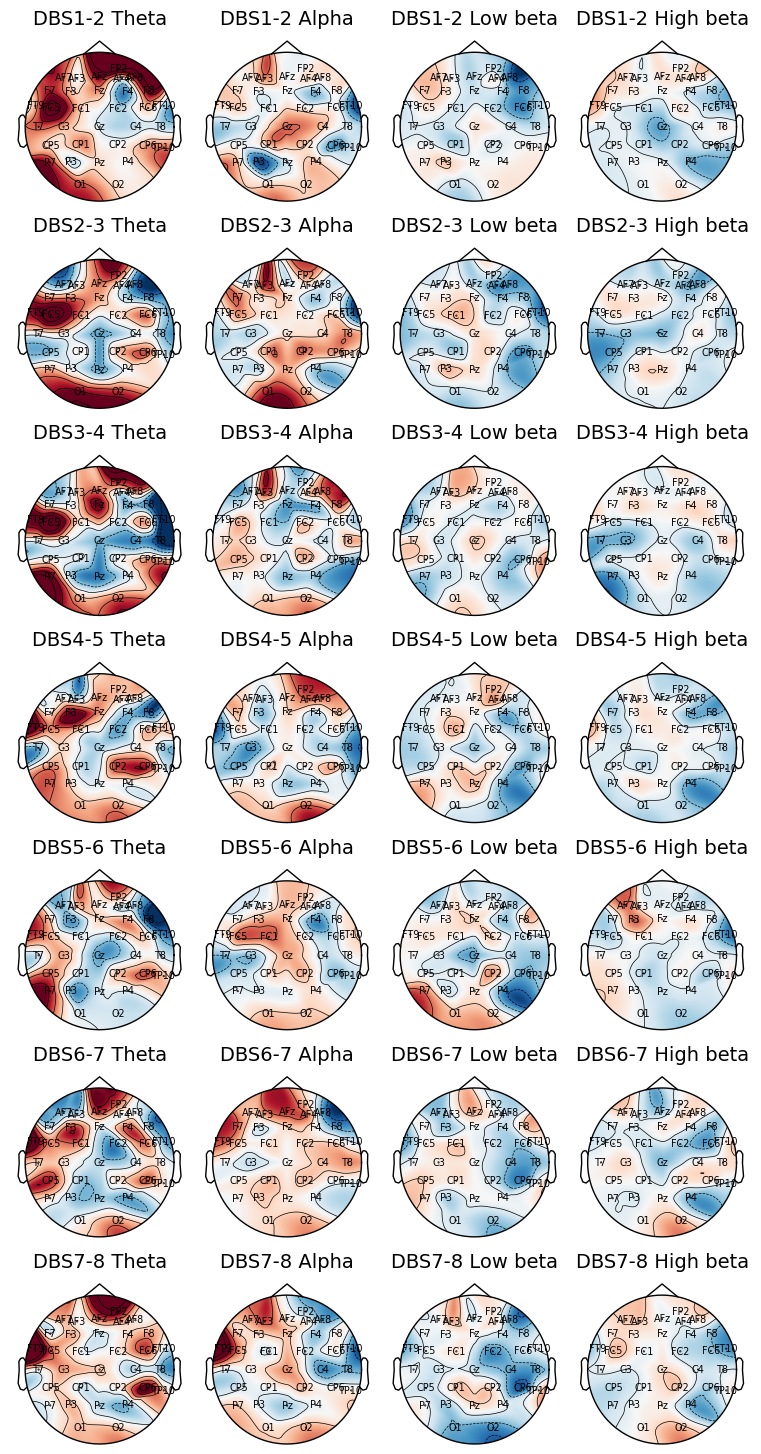

In [65]:
freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']
min_freq = [4, 8,13,21]
max_freq = [7, 12,20,30]

fig, axes = plt.subplots(figsize=(7.5, 14.5), nrows=len(seed_chs), ncols=len(freq_band), layout="constrained")

for n_ch, (axes_row, seed_ch) in enumerate(zip(axes, seed_chs)):

    n_channels = len(epochs_aff_odd1.copy().pick('eeg').ch_names)
    for n, (ax, band) in enumerate(zip(axes_row, freq_band)):
        tfr_evoked = mne.EvokedArray(coh_diff[n_ch,n,:,:], epochs_aff_odd1.copy().pick('eeg').info)
        tfr_evoked.plot_topomap(0.0,show_names=True,size=2,vlim=(-0.8e5,1e5),cmap='RdBu_r',axes=ax,show=False, colorbar =False)
        ax.set_title("%s %s" % (seed_ch.upper(), band), fontsize=14)


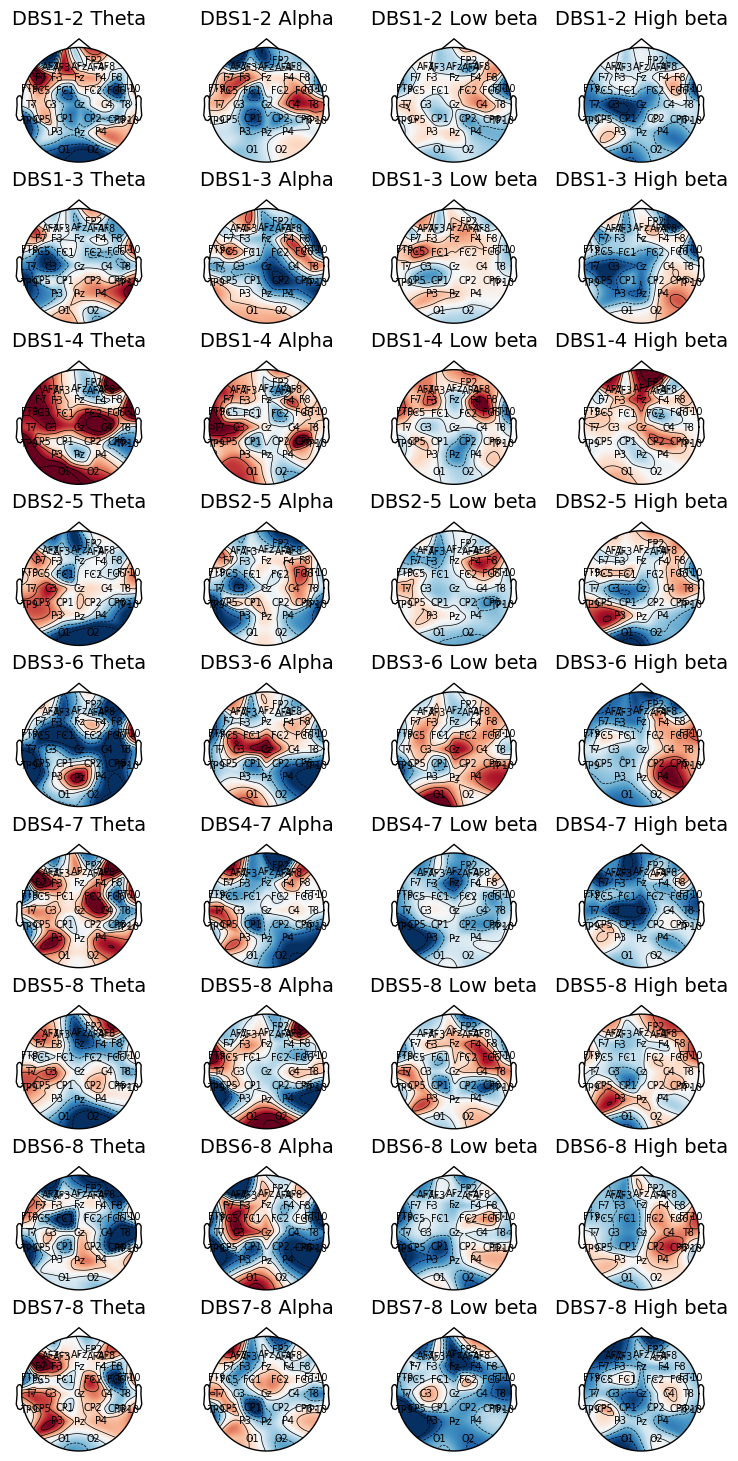

In [13]:
fig, axes = plt.subplots(figsize=(7.5, 14.5), nrows=len(seed_chs), ncols=len(freq_band), layout="constrained")

for n_ch, (axes_row, seed_ch) in enumerate(zip(axes, seed_chs)):

    n_channels = len(epochs_aff_odd1.copy().pick('eeg').ch_names)
    for n, (ax, band) in enumerate(zip(axes_row, freq_band)):
        tfr_evoked = mne.EvokedArray(coh_diff_ED[n_ch,n,:,:], epochs_aff_odd1.copy().pick('eeg').info)
        tfr_evoked.plot_topomap(0.0,show_names=True,size=2,vlim=(-0.8e5,1e5),cmap='RdBu_r',axes=ax,show=False, colorbar =False)
        ax.set_title("%s %s" % (seed_ch.upper(), band), fontsize=14)


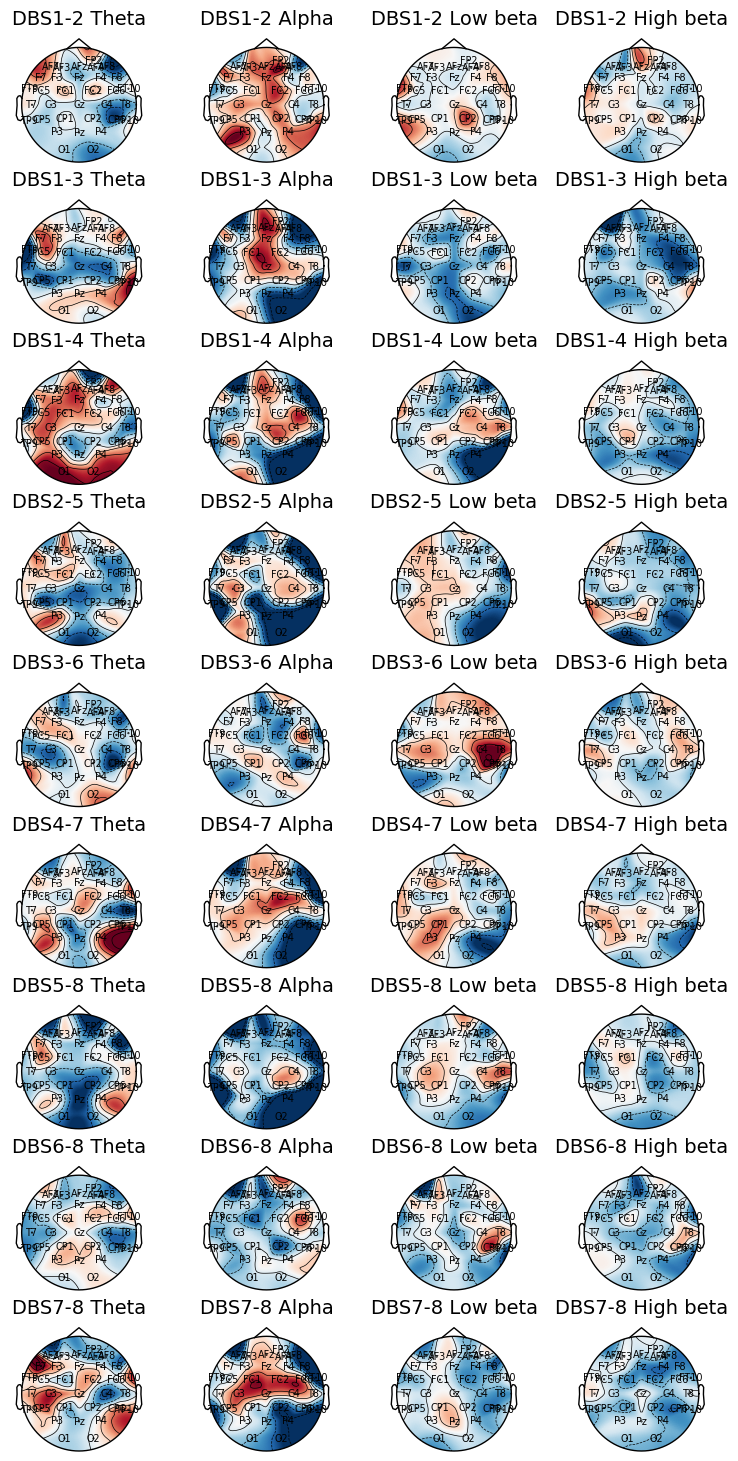

In [14]:
fig, axes = plt.subplots(figsize=(7.5, 14.5), nrows=len(seed_chs), ncols=len(freq_band), layout="constrained")

for n_ch, (axes_row, seed_ch) in enumerate(zip(axes, seed_chs)):

    n_channels = len(epochs_aff_odd1.copy().pick('eeg').ch_names)
    for n, (ax, band) in enumerate(zip(axes_row, freq_band)):
        tfr_evoked = mne.EvokedArray(coh_diff_EC[n_ch,n,:,:], epochs_aff_odd1.copy().pick('eeg').info)
        tfr_evoked.plot_topomap(0.0,show_names=True,size=2,vlim=(-0.8e5,1e5),cmap='RdBu_r',axes=ax,show=False, colorbar =False)
        ax.set_title("%s %s" % (seed_ch.upper(), band), fontsize=14)

Histogram and pvalue

In [138]:
base_dir

'E:/Oddball Data/'

Text(0.5, 0.98, 'C4')

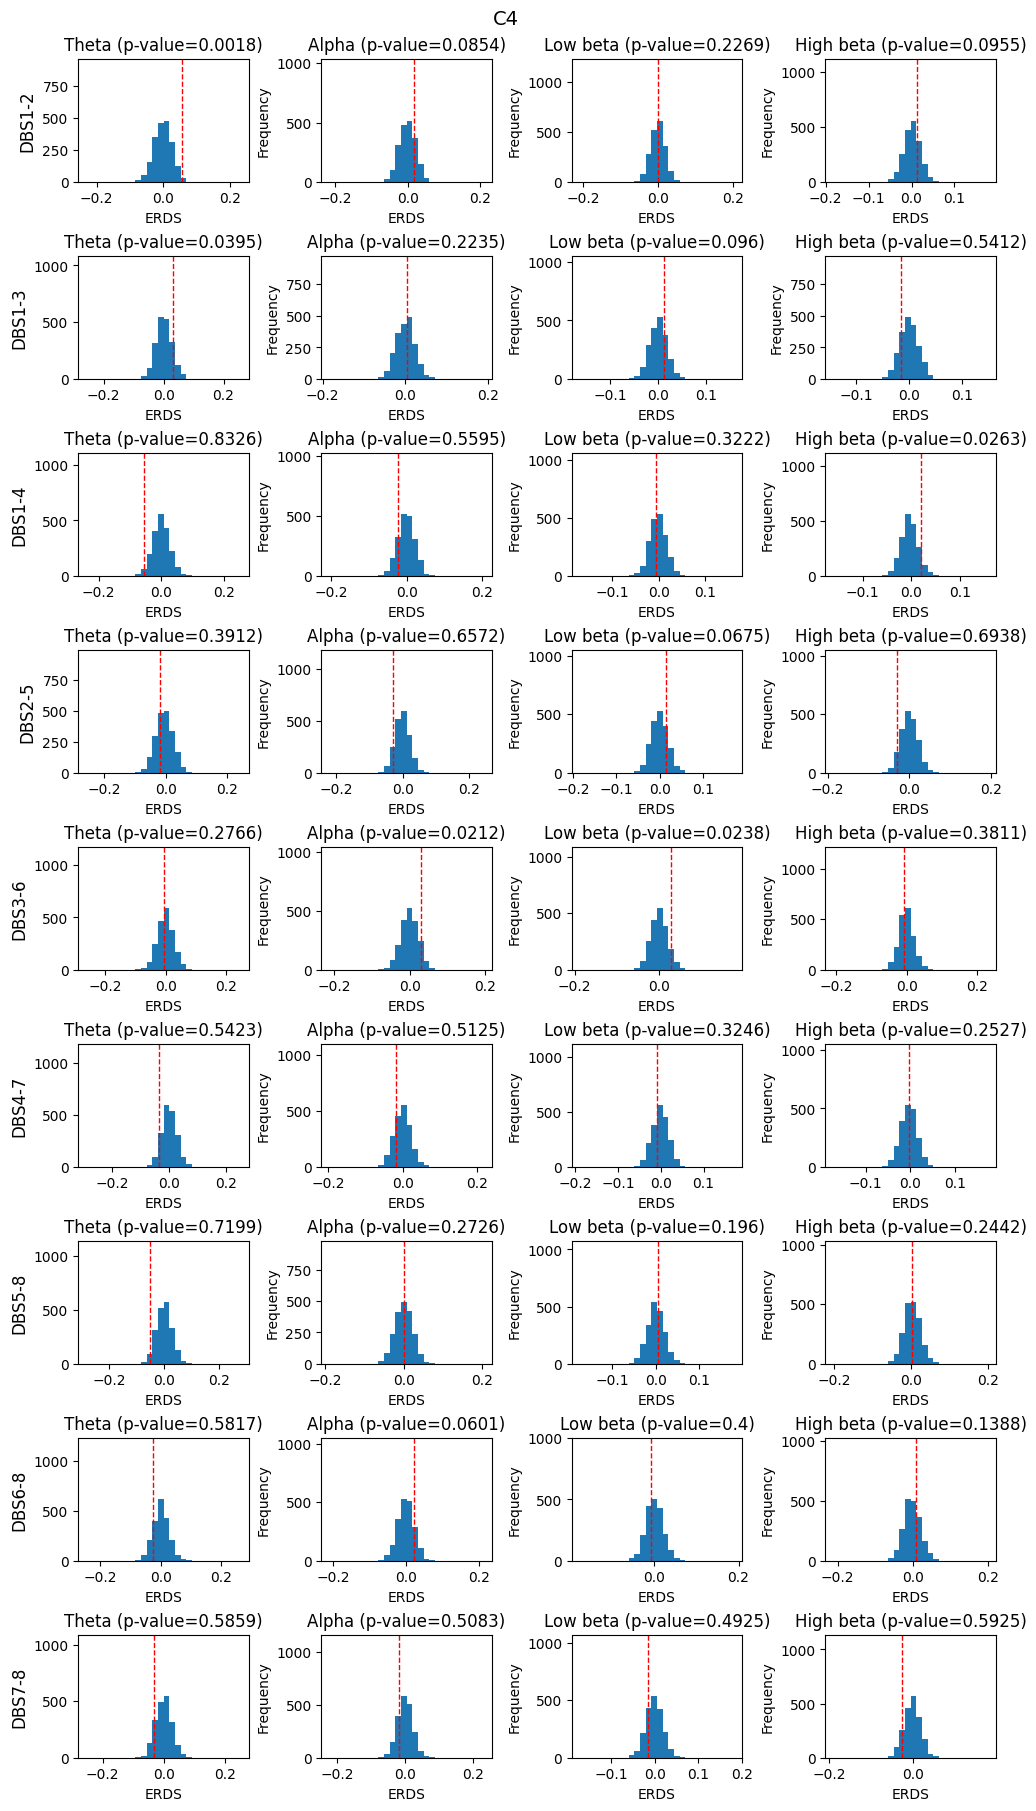

In [139]:
seed_chs = epochs_aff_odd1.copy().pick('dbs').ch_names
chl_list = epochs_aff_odd1.copy().pick('eeg').ch_names
freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']

chl_list = ['C4']


fig, axes = plt.subplots(len(seed_chs), 4, figsize=(10,18),layout="constrained")

mask = []

for n_seed, (seed_ch, ax) in enumerate(zip(seed_chs, axes)):
    mask1 =[]
    for nfrq, band in enumerate(freq_band):

        mask2 = []
        for nchls, ch in enumerate(chl_list):

          
            values, bins, _ = ax[nfrq].hist(coh_diff_permuted[:, n_seed, nfrq, nchls, :])
                      
            total_area = sum(np.diff(bins)*values)
            
            if coh_diff[n_seed, nfrq, nchls, : ][0] <= coh_diff_permuted[:, n_seed, nfrq, nchls, :].max():
            
                values, bins = np.histogram(coh_diff_permuted[:, n_seed, nfrq, nchls, :], range=(coh_diff[n_seed, nfrq, nchls, : ][0],coh_diff_permuted[:, n_seed, nfrq, nchls, :].max()))
                right_area = sum(np.diff(bins)*values)
                pval = right_area/total_area
                pval_r = round(pval, 4)
            else:
                pval_r = 'not significant'

            if pval <=0.05:
                mask2.append(pval)
            else:
                mask2.append(0)

            
            ax[nfrq].axvline(coh_diff[n_seed, nfrq, nchls, : ], color='r', linestyle='dashed', linewidth=1)
            ax[nfrq].set_ylabel('Frequency')
            ax[nfrq].set_xlabel('ERDS')

            ax[nfrq].set_title(f'{band} (p-value={pval_r})' )
            ax[nfrq].margins(1, 1)
        ax[0].set_ylabel(seed_ch, size='large')
    
        mask1.append(mask2)
    mask.append(mask1)
mask = np.array(mask)
fig.suptitle(chl_list[0], fontsize=14)


calculating p values

In [140]:
seed_chs = epochs_aff_odd1.copy().pick('dbs').ch_names
chl_list = epochs_aff_odd1.copy().pick('eeg').ch_names
freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']

pvals = []
for n_seed, (seed_ch, ax) in enumerate(zip(seed_chs, axes)):
    pvals1 = [] 
    for nfrq, band in enumerate(freq_band):

        pvals2 = []
        for nchls, ch in enumerate(chl_list):
         
            values, bins = np.histogram(coh_diff_permuted[:, n_seed, nfrq, nchls, :])
                      
            total_area = sum(np.diff(bins)*values)
            
            if coh_diff[n_seed, nfrq, nchls, : ][0] <= coh_diff_permuted[:, n_seed, nfrq, nchls, :].max():
            
                values, bins = np.histogram(coh_diff_permuted[:, n_seed, nfrq, nchls, :], range=(coh_diff[n_seed, nfrq, nchls, : ][0],coh_diff_permuted[:, n_seed, nfrq, nchls, :].max()))
                right_area = sum(np.diff(bins)*values)
                pval = right_area/total_area
                pval_r = round(pval, 4)
            else:
                pval_r = 0
            
            pvals2.append(pval_r)
        pvals2 = np.array(pvals2).reshape(n_channels,1)
   
        pvals1.append(pvals2)
    pvals.append(pvals1)
pvals = np.array(pvals)


In [141]:
n_channels

33

FDR correction for multiple comparison 

In [142]:
alpha = 0.05
pval_bonferroni = []
pval_fdr = []
mask_fdr = []

for nfrq, band in enumerate(freq_band):
    pval_bonferroni1 = []
    pval_fdr1 = []
    mask_fdr1 = []
    
    for nchls, ch in enumerate(chl_list):
        pvals_band = pvals[:,nfrq,nchls,:]
        n_samples , n_tests = pvals_band.shape
        reject_bonferroni, p_bon = mne.stats.bonferroni_correction(pvals_band, alpha=alpha)

        reject_fdr, p_fdr = mne.stats.fdr_correction(pvals_band, alpha=alpha, method="indep")

        mask_fdr1.append(reject_fdr)
        pval_bonferroni1.append(p_bon)
        pval_fdr1.append(p_fdr)
        
    pval_bonferroni.append(pval_bonferroni1)
    pval_fdr.append(pval_fdr1)
    mask_fdr.append(mask_fdr1)
    
pval_bonferroni = np.rollaxis(np.array(pval_bonferroni),2,0)
pval_fdr = np.rollaxis(np.array(pval_fdr),2,0)
mask_fdr = np.rollaxis(np.array(mask_fdr),2,0)

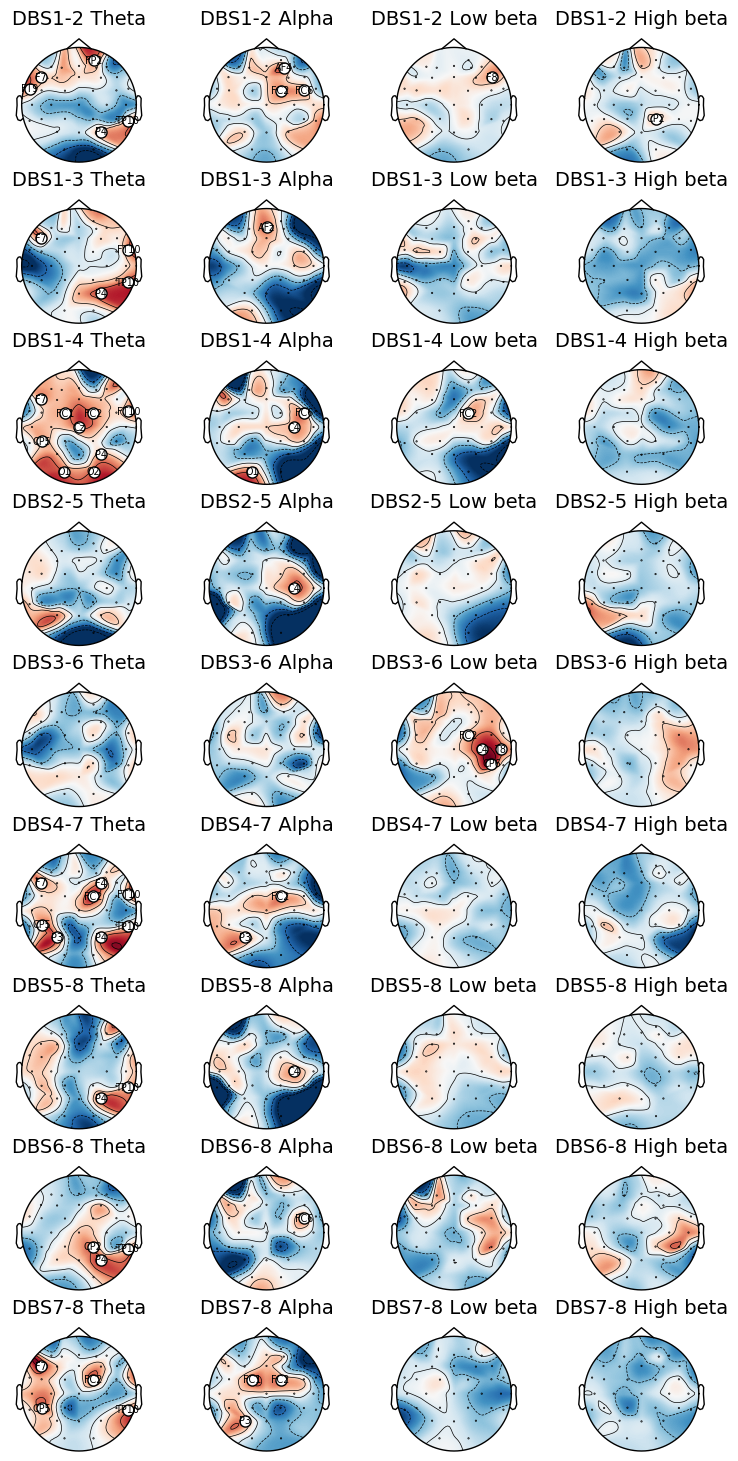

In [170]:
fig, axes = plt.subplots(figsize=(7.5, 14.5), nrows=len(seed_chs), ncols=len(freq_band), layout="constrained")

freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']
min_freq = [4, 8,13,21]
max_freq = [7, 12,20,30]
mask_params = dict(marker='o', markerfacecolor='w', markeredgecolor='k',
                    linewidth=0, markersize=8)
for n_ch, (axes_row, seed_ch) in enumerate(zip(axes, seed_chs)):

    n_channels = len(epochs_aff_odd.copy().pick('eeg').ch_names)
    for n, (ax, band) in enumerate(zip(axes_row, freq_band)):
        tfr_evoked = mne.EvokedArray(coh_diff[n_ch,n,:,:], epochs_aff_odd1.copy().pick('eeg').info)
        tfr_evoked.plot_topomap(0.0,show_names=True,size=2,mask=mask_fdr[n_ch,n,:,:], mask_params=mask_params, vlim=(-0.8e5,1e5),cmap='RdBu_r',axes=ax,show=False, colorbar =False)
        
        ax.set_title("%s %s" % (seed_ch.upper(), band), fontsize=14)


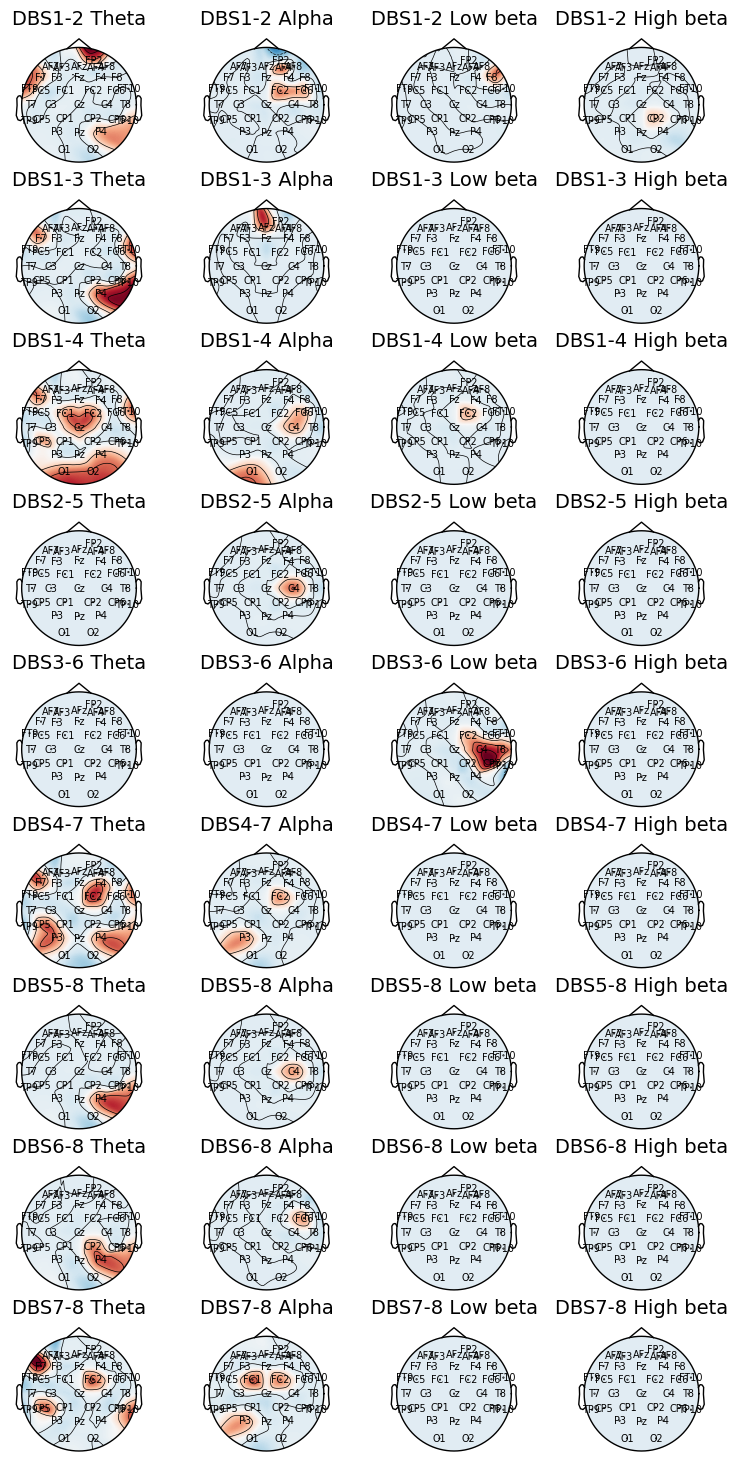

In [171]:
fig, axes = plt.subplots(figsize=(7.5, 14.5), nrows=len(seed_chs), ncols=len(freq_band), layout="constrained")
masked_coh = mask_fdr*coh_diff

freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']
min_freq = [4, 8,13,21]
max_freq = [7, 12,20,30]
mask_params = dict(marker='o', markerfacecolor='w', markeredgecolor='k',
                    linewidth=0, markersize=8)
for n_ch, (axes_row, seed_ch) in enumerate(zip(axes, seed_chs)):

    n_channels = len(epochs_aff_odd.copy().pick('eeg').ch_names)
    for n, (ax, band) in enumerate(zip(axes_row, freq_band)):
        tfr_evoked = mne.EvokedArray(masked_coh[n_ch,n,:,:], epochs_aff_odd1.copy().pick('eeg').info)
        tfr_evoked.plot_topomap(0.0,show_names=True,size=2, vlim=(-0.8e5,1e5),cmap='RdBu_r',axes=ax,show=False, colorbar =False)
        ax.set_title("%s %s" % (seed_ch.upper(), band), fontsize=14)


In [169]:
masked_coh = np.multiply(mask_fdr,coh_diff)


In [161]:
# check only for ipsilasional channels
ch_picks =['Fz','F4','F8','FC2','FC6','Cz', 'C4','CP2','CP6','Pz','P4']
masked_coh = np.multiply(mask_fdr,coh_diff)
mask_cluster_ipsi = np.zeros(masked_coh.shape)

for ch in ch_picks:
    
    mask_cluster_ipsi[:,:,picks_ch_names.index(ch),:] =+ masked_coh[:,:,picks_ch_names.index(ch),:]
    print(picks_ch_names.index(ch))
    

8
7
6
12
11
17
16
22
21
28
27


In [168]:
masked_coh[0,0,6,:]

array([-0.])

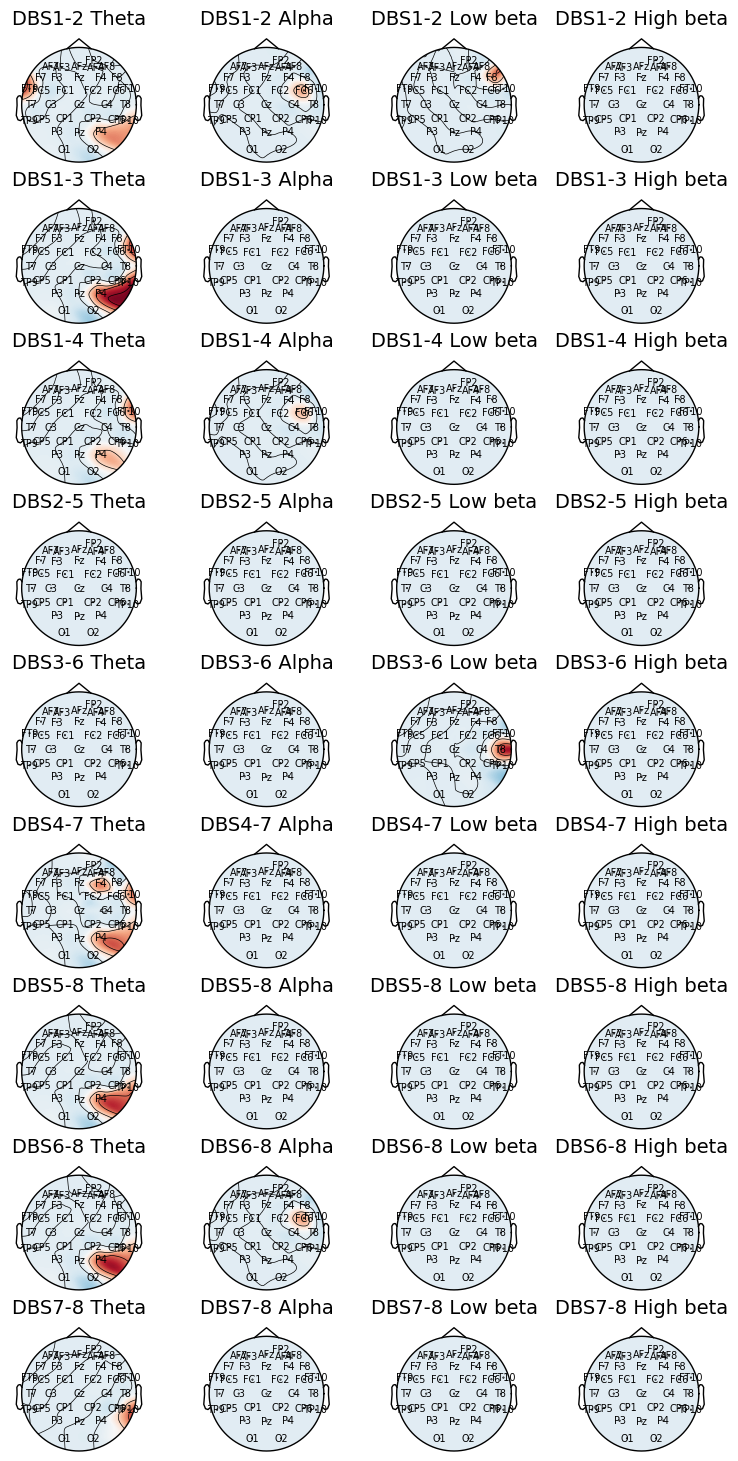

In [143]:
# check only for ipsilasional channels
ch_picks =['Fz','F4','F8','FC2','FC6','Cz', 'C4','CP2','CP6','Pz','P4']
masked_coh = np.multiply(mask_fdr,coh_diff)
mask_cluster_ipsi = np.zeros(masked_coh.shape)

for ch in ch_picks:
    
    mask_cluster_ipsi[:,:,picks_ch_names.index(ch),:] = masked_coh[:,:,picks_ch_names.index(ch),:]
    
fig, axes = plt.subplots(figsize=(7.5, 14.5), nrows=len(seed_chs), ncols=len(freq_band), layout="constrained")

freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']
min_freq = [4, 8,13,21]
max_freq = [7, 12,20,30]
mask_params = dict(marker='o', markerfacecolor='w', markeredgecolor='k',
                    linewidth=0, markersize=8)
for n_ch, (axes_row, seed_ch) in enumerate(zip(axes, seed_chs)):

    n_channels = len(epochs_aff_odd.copy().pick('eeg').ch_names)
    for n, (ax, band) in enumerate(zip(axes_row, freq_band)):
        tfr_evoked = mne.EvokedArray(mask_cluster_ipsi[n_ch,n,:,:], epochs_aff_odd1.copy().pick('eeg').info)
        tfr_evoked.plot_topomap(0.0,show_names=True,size=2, vlim=(-0.8e5,1e5),cmap='RdBu_r',axes=ax,show=False, colorbar =False)
        ax.set_title("%s %s" % (seed_ch.upper(), band), fontsize=14)
    
    

In [128]:
# cluster size thresholding. Selecting clusters with more than 3 electrodes


# check only for ipsilasional channels
ch_picks =['Fz','F4','F8','FC2','FC6','Cz', 'C4','CP2','CP6','Pz','P4']
masked_coh = np.multiply(mask_fdr,coh_diff)
mask_cluster_ipsi = np.zeros(masked_coh.shape)

for ch in ch_picks:
    
    mask_cluster_ipsi[:,:,picks_ch_names.index(ch),:] = masked_coh[:,:,picks_ch_names.index(ch),:]


masked_coh = mask_cluster_ipsi
mask_cluster_size = np.zeros(masked_coh.shape)
mask_cluster_vol = np.zeros(masked_coh.shape)

adj, names = mne.channels.find_ch_adjacency(epochs_aff_odd1.info, 'eeg')

clus_size_thres = 1

freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']
min_freq = [4, 8,13,21]
max_freq = [7, 12,20,30]
sig_clus_vol = []
sig_dbs_ch = []
sig_band_ch = []
sig_eeg_ch = []



for n_ch, seed_ch in enumerate(seed_chs):

    n_channels = len(epochs_aff_odd.copy().pick('eeg').ch_names)
    for n, band in enumerate(freq_band):
        tfr_evoked = mne.EvokedArray(masked_coh[n_ch,n,:,:], epochs_aff_odd1.copy().pick('eeg').info)
        for n_eeg, ch_eeg in enumerate(tfr_evoked.ch_names):
            if tfr_evoked.get_data()[n_eeg]>0.001:
                neigh_idx = np.where(adj[n_eeg, :].toarray().ravel())[0]
                neigh_names = [names[i] for i in neigh_idx]
                #print(f"{tfr_evoked.ch_names[n_eeg]} is next to {neigh_names}")
                
                ch_neigh_names = []
                
                for n_neigh, ch_neigh in enumerate(neigh_names):
                    if tfr_evoked.copy().pick(ch_neigh).get_data()>0.001:
                        ch_neigh_names.append(ch_neigh)
                cluster_size = len(ch_neigh_names)
                #print(cluster_size)
                #print(ch_neigh_names)
                if cluster_size>=clus_size_thres:
                    mask_cluster_amp = []
                    mask_cluster_ind = []

                    print(ch_neigh_names)
                    for n_cs, cs in enumerate(ch_neigh_names):
                        cs_ind = names.index(cs)

                        #print(cs)
                        #print(cs_ind)
                        mask_cluster_size[n_ch,n,cs_ind,:] = masked_coh[n_ch,n,cs_ind,:]

                        mask_cluster_amp.append(masked_coh[n_ch,n,cs_ind,:])
                        mask_cluster_ind.append(cs_ind)
                    # volume of the cluster 
                    sig_clus_vol.append(sum(mask_cluster_amp)*len(mask_cluster_amp))
                    sig_clus_vol1 = sum(mask_cluster_amp)*len(mask_cluster_amp)
                    print(mask_cluster_ind)
                    print(sum(mask_cluster_amp))

print(sig_clus_vol)


for n_ch, seed_ch in enumerate(seed_chs):

    n_channels = len(epochs_aff_odd.copy().pick('eeg').ch_names)
    for n, band in enumerate(freq_band):
        tfr_evoked = mne.EvokedArray(masked_coh[n_ch,n,:,:], epochs_aff_odd1.copy().pick('eeg').info)
        for n_eeg, ch_eeg in enumerate(tfr_evoked.ch_names):
            if tfr_evoked.get_data()[n_eeg]>0.001:
                neigh_idx = np.where(adj[n_eeg, :].toarray().ravel())[0]
                neigh_names = [names[i] for i in neigh_idx]
                #print(f"{tfr_evoked.ch_names[n_eeg]} is next to {neigh_names}")
                
                ch_neigh_names = []
                
                for n_neigh, ch_neigh in enumerate(neigh_names):
                    if tfr_evoked.copy().pick(ch_neigh).get_data()>0.001:
                        ch_neigh_names.append(ch_neigh)
                cluster_size = len(ch_neigh_names)
                #print(cluster_size)
                #print(ch_neigh_names)
                if cluster_size>=clus_size_thres:
                    
                    mask_cluster_amp = []
                    mask_cluster_ind = []
                    print(ch_neigh_names)
                    for n_cs, cs in enumerate(ch_neigh_names):
                        cs_ind = names.index(cs)

                        #print(cs)
                        #print(cs_ind)
                        mask_cluster_size[n_ch,n,cs_ind,:] = masked_coh[n_ch,n,cs_ind,:]

                        mask_cluster_amp.append(masked_coh[n_ch,n,cs_ind,:])
                        mask_cluster_ind.append(cs_ind)
                    # volume of the cluster 
                    sig_clus_vol1 = sum(mask_cluster_amp)*len(mask_cluster_amp)
                    #print(mask_cluster_ind)
                    if sig_clus_vol1 == max(sig_clus_vol) :
                        print(mask_cluster_ind)
                        sig_eeg_ch = mask_cluster_ind
                        for c_ind in mask_cluster_ind:
                            mask_cluster_vol[n_ch,n,c_ind,:] = masked_coh[n_ch,n,c_ind,:]
                            #sig_eeg_ch.append(c_ind)
                        sig_dbs_ch.append(n_ch)
                        sig_band_ch.append(n)
                            
                  

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 33
['FT9']
[16]
[0.05063162]
['TP10', 'P4']
[22, 28]
[0.07671159]
['TP10', 'P4']
[22, 28]
[0.07671159]
['FC6']
[12]
[0.04195283]
['F8']
[6]
[0.04637879]
['FT10', 'TP10']
[11, 22]
[0.12439783]
['FT10', 'TP10', 'P4']
[11, 22, 28]
[0.1955052]
['TP10', 'P4']
[22, 28]
[0.14040624]
['FT10']
[11]
[0.0485297]
['P4']
[28]
[0.03721105]
['FC6']
[12]
[0.03689647]
['T8']
[17]
[0.07194301]
['F4']
[7]
[0.05360999]
['FT10', 'TP10']
[11, 22]
[0.07635271]
['FT10', 'TP10', 'P4']
[11, 22, 28]
[0.12969771]
['TP10', 'P4']
[22, 28]
[0.08671591]
['TP10', 'P4']
[22, 28]
[0.10530239]
['TP10', 'P4']
[22, 28]
[0.10530239]
['TP10', 'P4']
[22, 28]
[0.10648589]
['TP10', 'P4']
[22, 28]
[0.10648589]
['FC6']
[12]
[0.04563406]
['TP10']
[22]
[0.05185641]
[array([0.05063162]), array([0.15342319]), array([0.15342319]), array([0.04195283]), array([0.04637879]), array([0.24879567]), array([0.

In [ ]:
fig, axes = plt.subplots(figsize=(7.5, 14.5), nrows=len(seed_chs), ncols=len(freq_band), layout="constrained")

freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']
min_freq = [4, 8,13,21]
max_freq = [7, 12,20,30]
mask_params = dict(marker='o', markerfacecolor='w', markeredgecolor='k',
                    linewidth=0, markersize=8)
for n_ch, (axes_row, seed_ch) in enumerate(zip(axes, seed_chs)):

    n_channels = len(epochs_aff_odd.copy().pick('eeg').ch_names)
    for n, (ax, band) in enumerate(zip(axes_row, freq_band)):
        tfr_evoked = mne.EvokedArray(mask_cluster_size[n_ch,n,:,:], epochs_aff_odd1.copy().pick('eeg').info)
        tfr_evoked.plot_topomap(0.0,show_names=True,size=2, vlim=(-0.8e5,1e5),cmap='RdBu_r',axes=ax,show=False, colorbar =False)
        ax.set_title("%s %s" % (seed_ch.upper(), band), fontsize=14)


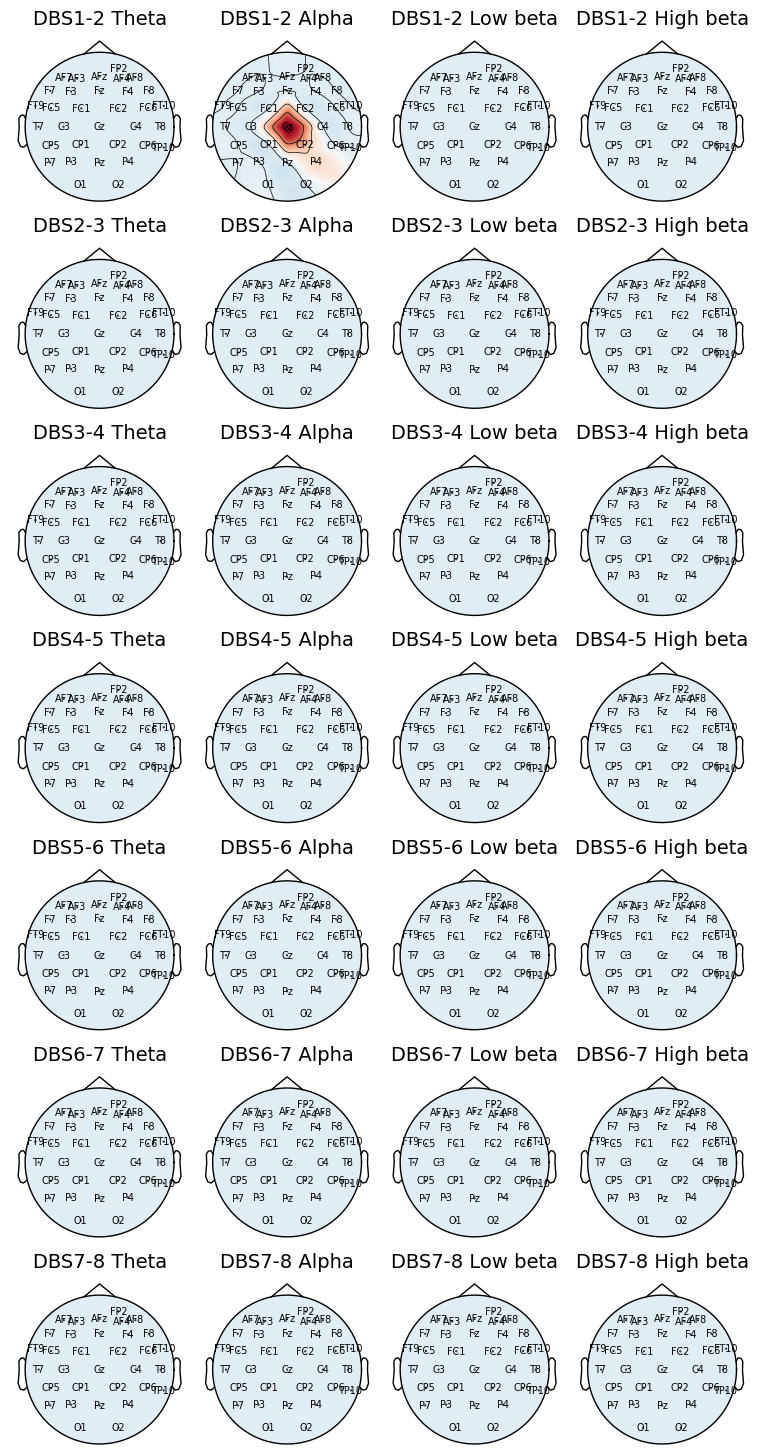

In [93]:
# Selecting best DBS contact based on Volume of the cluster (amplitude of the cluster* number of electrodes) 

fig, axes = plt.subplots(figsize=(7.5, 14.5), nrows=len(seed_chs), ncols=len(freq_band), layout="constrained")

freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']
min_freq = [4, 8,13,21]
max_freq = [7, 12,20,30]
mask_params = dict(marker='o', markerfacecolor='w', markeredgecolor='k',
                    linewidth=0, markersize=8)
for n_ch, (axes_row, seed_ch) in enumerate(zip(axes, seed_chs)):

    n_channels = len(epochs_aff_odd.copy().pick('eeg').ch_names)
    for n, (ax, band) in enumerate(zip(axes_row, freq_band)):
        tfr_evoked = mne.EvokedArray(mask_cluster_vol[n_ch,n,:,:], epochs_aff_odd1.copy().pick('eeg').info)
        tfr_evoked.plot_topomap(0.0,show_names=True,size=2, vlim=(-0.8e5,1e5),cmap='RdBu_r',axes=ax,show=False, colorbar =False)
        ax.set_title("%s %s" % (seed_ch.upper(), band), fontsize=14)


In [129]:
print(sig_dbs_ch)
print(sig_band_ch)
print(sig_eeg_ch)

[1]
[0]
[11, 22, 28]


In [130]:
[epochs_aff_odd1.copy().pick(['dbs']).ch_names[sig_dbs_ch[0]]]

['DBS1-3']

Text(0.5, 1.0, 'DBS1-3 Theta')

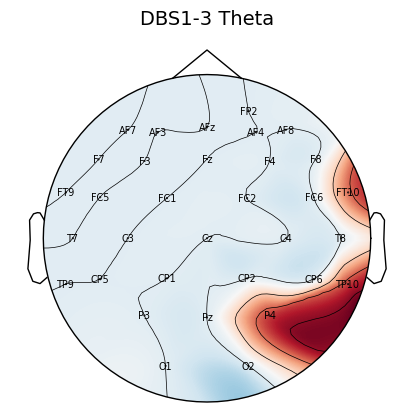

In [131]:
# Selecting best DBS contact based on Volume of the cluster (amplitude of the cluster* number of electrodes) 

fig, ax = plt.subplots(1,1)
mask_params = dict(marker='o', markerfacecolor='w', markeredgecolor='k',
                    linewidth=0, markersize=8)

tfr_evoked = mne.EvokedArray(mask_cluster_vol[sig_dbs_ch[0],sig_band_ch[0],:,:], epochs_aff_odd1.copy().pick('eeg').info)
tfr_evoked.plot_topomap(0.0,show_names=True,size=2, vlim=(-0.8e5,1e5), cmap='RdBu_r', colorbar =False, show=False,image_interp='cubic', extrapolate='head', border='mean', res=64, axes = ax)

ax.set_title(f"{epochs_aff_odd1.copy().pick(['dbs']).ch_names[sig_dbs_ch[0]]} {freq_band[sig_band_ch[0]]}", fontsize=14)


Plot Significant TFR Coherence

In [77]:
""""Coherence"""

sig_dbs_ch
sig_eeg_ch

sig_eeg = []
for n, i in enumerate(sig_eeg_ch):
    sig_eeg.append(epochs_aff_odd1.copy().pick(['eeg']).ch_names[sig_eeg_ch[n]])


sig_seed_ch = [epochs_aff_odd1.copy().pick(['dbs']).ch_names[sig_dbs_ch[0]]]

picks = mne.pick_types(epochs_aff_odd1.info, eeg=True, dbs=True, emg= False,stim=False, eog=False,
                       exclude='bads')

epochs_aff_odd1.pick(['eeg','dbs'])
epochs_aff_typ1.pick(['eeg','dbs'])

# Use 'DBS' channels as seed
        
coh_diff = []
for seed_ch in sig_seed_ch:
    
    picks_ch_names = epochs_aff_odd1.ch_names
    # Create seed-target indices for connectivity computation
    seed = picks_ch_names.index(seed_ch)
    targets = np.arange(len(picks))
    indices = seed_target_indices(seed, targets)
    
    min_freq = (4, 8,13,21)
    max_freq = (7, 12,20,30)

    
    # Define wavelet frequencies and number of cycles
    cwt_freqs = np.arange(1, 41, 1)
    cwt_n_cycles = 7

    # Run the connectivity analysis using n parallel jobs
    con_odd = spectral_connectivity_epochs(
        epochs_aff_odd1, indices=indices,
        method='coh', mode='cwt_morlet', sfreq=sfreq, 
        cwt_freqs=cwt_freqs, cwt_n_cycles=cwt_n_cycles, n_jobs=2)

    con_typ = spectral_connectivity_epochs(
        epochs_aff_typ1, indices=indices,
        method='coh', mode='cwt_morlet', sfreq=sfreq, 
        cwt_freqs=cwt_freqs, cwt_n_cycles=cwt_n_cycles, n_jobs=2)

    times = con_odd.times
    freqs = con_odd.freqs

    # Mark the seed channel with a value of 1.0, so we can see it in the plot
    # con_odd.get_data()[np.where(indices[1] == seed)] = 1.0
    # con_typ.get_data()[np.where(indices[1] == seed)] = 1.0

    #layout = mne.find_layout(epochs.info, 'eeg')  # use full layout
    tfr_odd = mne.time_frequency.AverageTFR(epochs_aff_odd1.info, con_odd.get_data(), times, freqs, len(epochs_aff_odd1))
    #tfr_odd.save(data_dir+'tfr_odd'+st+seed_ch+'-tfr.h5',overwrite =True)

    tfr_typ = mne.time_frequency.AverageTFR(epochs_aff_typ1.info, con_typ.get_data(), times, freqs, len(epochs_aff_typ1))
    #tfr_typ.save(data_dir+'tfr_typ'+st+seed_ch+'-tfr.h5',overwrite =True)
    
    # TFR differences in freq bands and time period 0 to 1.5s

    tfr_diff = tfr_odd- tfr_typ


Connectivity computation...
    computing connectivity for 40 connections
    using t=-3.000s..6.000s for estimation (1801 points)
    frequencies: 1.0Hz..40.0Hz (40 points)
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..2


C:\Users\malann\AppData\Local\Temp\ipykernel_902196\871113445.py:39: RuntimeWarning: There were no Annotations stored in <EpochsArray |  78 events (all good), -3 – 6 s, baseline off, ~42.9 MB, data loaded,
 '101': 78>, so metadata was not modified.
  con_odd = spectral_connectivity_epochs(
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 3..4


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    5.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 5..6


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 7..8


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 9..10


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 11..12


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 13..14


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 15..16


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 17..18


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 19..20


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 21..22


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 23..24


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 25..26


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 27..28


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 29..30


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 31..32


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 33..34


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 35..36


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 37..38


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 39..40


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 41..42


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 43..44


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 45..46


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 47..48


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 49..50


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 51..52


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 53..54


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 55..56


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 57..58


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 59..60


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 61..62


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 63..64


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 65..66


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 67..68


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 69..70


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 71..72


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 73..74


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 75..76


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 77..78


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.2s finished


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 40 connections
    using t=-3.000s..6.000s for estimation (1801 points)
    frequencies: 1.0Hz..40.0Hz (40 points)
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epochs 1..2


C:\Users\malann\AppData\Local\Temp\ipykernel_902196\871113445.py:44: RuntimeWarning: There were no Annotations stored in <EpochsArray |  78 events (all good), -3 – 6 s, baseline off, ~42.9 MB, data loaded,
 '1': 78>, so metadata was not modified.
  con_typ = spectral_connectivity_epochs(
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 3..4


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 5..6


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 7..8


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 9..10


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 11..12


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 13..14


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 15..16


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 17..18


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 19..20


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 21..22


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 23..24


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 25..26


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 27..28


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 29..30


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 31..32


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 33..34


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 35..36


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 37..38


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 39..40


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 41..42


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 43..44


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 45..46


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 47..48


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 49..50


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 51..52


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 53..54


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 55..56


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 57..58


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 59..60


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 61..62


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 63..64


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 65..66


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 67..68


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 69..70


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 71..72


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 73..74


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 75..76


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing connectivity for epochs 77..78


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.5s finished


[Connectivity computation done]


No baseline correction applied
No baseline correction applied


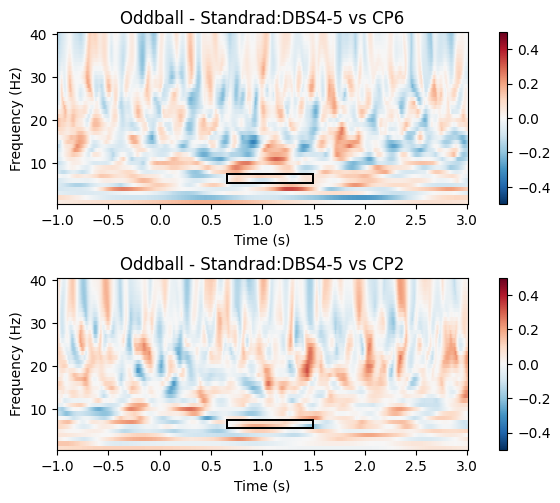

In [78]:
# creating a mask to plot on tfr coherence betwwn 0s and 1.5s and significant freq band
tmin = -1
tmax = 3

tmin_mark = tmin_coh_lst[1]
tmax_mark = tmax_coh_lst[1]
fmin_mark = min_freq[sig_band_ch[0]]
fmax_mark = max_freq[sig_band_ch[0]]

mask_tfr_diff = np.full(tfr_diff.copy().crop(tmin,tmax).pick(sig_eeg).data.shape, False)


for n in range(0,tfr_diff.copy().crop(tmin,tmax).data.shape[1]):
    for m in range(0,tfr_diff.copy().crop(tmin,tmax).data.shape[2]):
        if n>fmin_mark and n<fmax_mark and m > (tmin_mark-tmin)*200 and m < (tmax_mark-tmin)*200:
            mask_tfr_diff[:,n,m]= True
            
vmax=0.5
vmin=-0.5
fig, axes = plt.subplots(figsize=(5.5, 2.5*len(sig_eeg_ch)), nrows=len(sig_eeg_ch), ncols=1, layout="constrained")
for i, (ax, ch) in enumerate(zip(axes, tfr_diff.copy().pick(sig_eeg).ch_names)):
    title = 'Oddball - Standrad:' + seed_ch +' vs '+ch 
    tfr_diff.plot(ch, tmin=tmin,tmax=tmax, axes = ax, vmax=vmax,vmin=vmin, mask =mask_tfr_diff[i,:,:] ,mask_style = 'contour', show= False)
    ax.set_title(title)

Coherence Excel sheet 

In [22]:
df = tfr_diff.copy().pick(sig_eeg).to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {"_": 0, "[0 3]": 4, "[4 7]": 8, "[8 12]": 13, "[13 20]": 20, "[21 30]": 30}
time_bounds = {"_": -0.5, "[-0.5 0]": 0, f'[0 {f_max_time} ]': f_max_time, f'[{f_max_time} 1.1]': 1.1, "[1.1, 1.5]": 1.5, "[1.5 2]": 2}

df["band"] = pd.cut(
    df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
)

df["Time_dur"] = pd.cut(
    df["time"], list(time_bounds.values()), labels=list(time_bounds)[1:]
)

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ["[4 7]","[8 12]", "[13 20]", "[21 30]"]
time_of_interest = ["[-0.5 0]", f'[0 {f_max_time} ]', f'[{f_max_time} 1.1]', "[1.1, 1.5]", "[1.5 2]"]

df = df[df.band.isin(freq_bands_of_interest)]
df = df[df.Time_dur.isin(time_of_interest)]

df["band"] = df["band"].cat.remove_unused_categories()
df["Time_dur"] = df["Time_dur"].cat.remove_unused_categories()


df_mean = (
    df.groupby(["Time_dur", "band", "channel"], observed=False)[["value"]]
    .mean()
    .reset_index()
)
df_mean.insert(0,'Stage', len(df_mean)*[st])
df_mean.insert(1,'Subject', len(df_mean)*[sub])
df_mean.insert(4,'DBS Channel', len(df_mean)*[sig_seed_ch])

Converting "channel" to "category"...
Converting "ch_type" to "category"...


In [23]:
df_mean

Stage Subject     Time_dur     band DBS Channel channel     value
0   implant     014     [-0.5 0]    [4 7]    [DBS3-4]      Cz -0.009392
1   implant     014     [-0.5 0]    [4 7]    [DBS3-4]      P4  0.022333
2   implant     014     [-0.5 0]    [4 7]    [DBS3-4]      Pz  0.033370
3   implant     014     [-0.5 0]   [8 12]    [DBS3-4]      Cz -0.023876
4   implant     014     [-0.5 0]   [8 12]    [DBS3-4]      P4  0.015470
5   implant     014     [-0.5 0]   [8 12]    [DBS3-4]      Pz -0.038393
6   implant     014     [-0.5 0]  [13 20]    [DBS3-4]      Cz  0.035531
7   implant     014     [-0.5 0]  [13 20]    [DBS3-4]      P4  0.004059
8   implant     014     [-0.5 0]  [13 20]    [DBS3-4]      Pz  0.027870
9   implant     014     [-0.5 0]  [21 30]    [DBS3-4]      Cz  0.094308
10  implant     014     [-0.5 0]  [21 30]    [DBS3-4]      P4 -0.036376
11  implant     014     [-0.5 0]  [21 30]    [DBS3-4]      Pz  0.025535
12  implant     014   [0 0.845 ]    [4 7]    [DBS3-4]      Cz -0.004553
13  implant     014   [0 0.845 ]    [4 7]    [DBS3-4]      P4  0.032381
14  implant     014   [0 0.845 ]    [4 7]    [DBS3-4]      Pz  0.038210
15  implant     014   [0 0.845 ]   [8 12]    [DBS3-4]      Cz -0.030949
16  implant     014   [0 0.845 ]   [8 12]    [DBS3-4]      P4  0.048492
17  implant     014   [0 0.845 ]   [8 12]    [DBS3-4]      Pz  0.000643
18  implant     014   [0 0.845 ]  [13 20]    [DBS3-4]      Cz -0.028137
19  implant     014   [0 0.845 ]  [13 20]    [DBS3-4]      P4  0.012101
20  implant     014   [0 0.845 ]  [13 20]    [DBS3-4]      Pz -0.008239
21  implant     014   [0 0.845 ]  [21 30]    [DBS3-4]      Cz  0.023334
22  implant     014   [0 0.845 ]  [21 30]    [DBS3-4]      P4 -0.003595
23  implant     014   [0 0.845 ]  [21 30]    [DBS3-4]      Pz  0.008262
24  implant     014  [0.845 1.1]    [4 7]    [DBS3-4]      Cz  0.083699
25  implant     014  [0.845 1.1]    [4 7]    [DBS3-4]      P4 -0.005108
26  implant     014  [0.845 1.1]    [4 7]    [DBS3-4]      Pz  0.145588
27  implant     014  [0.845 1.1]   [8 12]    [DBS3-4]      Cz  0.079479
28  implant     014  [0.845 1.1]   [8 12]    [DBS3-4]      P4  0.040557
29  implant     014  [0.845 1.1]   [8 12]    [DBS3-4]      Pz  0.007399
30  implant     014  [0.845 1.1]  [13 20]    [DBS3-4]      Cz  0.004681
31  implant     014  [0.845 1.1]  [13 20]    [DBS3-4]      P4 -0.018646
32  implant     014  [0.845 1.1]  [13 20]    [DBS3-4]      Pz  0.021566
33  implant     014  [0.845 1.1]  [21 30]    [DBS3-4]      Cz -0.002375
34  implant     014  [0.845 1.1]  [21 30]    [DBS3-4]      P4 -0.016230
35  implant     014  [0.845 1.1]  [21 30]    [DBS3-4]      Pz  0.054942
36  implant     014   [1.1, 1.5]    [4 7]    [DBS3-4]      Cz  0.030291
37  implant     014   [1.1, 1.5]    [4 7]    [DBS3-4]      P4 -0.027753
38  implant     014   [1.1, 1.5]    [4 7]    [DBS3-4]      Pz  0.034003
39  implant     014   [1.1, 1.5]   [8 12]    [DBS3-4]      Cz -0.024103
40  implant     014   [1.1, 1.5]   [8 12]    [DBS3-4]      P4  0.013791
41  implant     014   [1.1, 1.5]   [8 12]    [DBS3-4]      Pz -0.006917
42  implant     014   [1.1, 1.5]  [13 20]    [DBS3-4]      Cz  0.047883
43  implant     014   [1.1, 1.5]  [13 20]    [DBS3-4]      P4  0.005335
44  implant     014   [1.1, 1.5]  [13 20]    [DBS3-4]      Pz  0.033933
45  implant     014   [1.1, 1.5]  [21 30]    [DBS3-4]      Cz  0.034692
46  implant     014   [1.1, 1.5]  [21 30]    [DBS3-4]      P4 -0.002534
47  implant     014   [1.1, 1.5]  [21 30]    [DBS3-4]      Pz  0.057099
48  implant     014      [1.5 2]    [4 7]    [DBS3-4]      Cz -0.042869
49  implant     014      [1.5 2]    [4 7]    [DBS3-4]      P4  0.045820
50  implant     014      [1.5 2]    [4 7]    [DBS3-4]      Pz  0.045631
51  implant     014      [1.5 2]   [8 12]    [DBS3-4]      Cz  0.016256
52  implant     014      [1.5 2]   [8 12]    [DBS3-4]      P4  0.032310
53  implant     014      [1.5 2]   [8 12]    [DBS3-4]      Pz  0.042384
54  implant     014      [1.5 2]  [13 20]    [

In [24]:
df_mean.to_csv(base_dir+'Oddball_Coh_data.csv', mode='a', index=False, header=False)
